In [220]:
import numpy as np
import csv
import os
import random
import json
from keras.models import load_model
import sys
import time
import math
from queue import PriorityQueue
from numba import jit, cuda

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


# Parameter
INPUT_PATH = "./CSV/"
INPUT_FBFILE_PATH = "./FB2010-1Hr-150-0.txt"
INPUT_MODEL = "./Coflow_model_select.h5"
INPUT_MINMAX = "./min_max.json"
OUTPUT_CSV = "./P4_RECORD/priority_table_size"
OUTPUT_ACCURACY = "./P4_RECORD/classify_record"
OUTPUT_COMPLETION_TIME = "./P4_RECORD/coflow_completion_time"


with open(INPUT_MINMAX) as file_object:
    min_max = json.load(file_object)
    min_data = np.array(min_max['min_num'])
    max_data = np.array(min_max['max_num'])

MODEL = load_model(INPUT_MODEL)

counter = 0
# Data Set
fb_data = {}
fb_coflow_size = {}
fb_coflow_priority = {}
mapping_to_grouping_table = {}
current_global_coflow_size = {} #key=cid, value=size
global_coflow_size = {}
coflow_size_estimation_record = {} #key=counter, value=[real cid, global size, mapping size, [local sizes], [queue sizes]]
priority_result = {}
priority_done = set()
priority_accuracy = {} #key=counter, value=[[average accuracy(w/o mapping)], [average accuracy(top k)(w/o mapping)], [average distance (w/o mapping)]]
partial_accuracy_improvement = {} #key=timer, value=[accuracy with single adjustment, accuracy with full adjustment]

In [221]:
# COFLOW_NUMBER = 100
# FLOW_NUMBER = 10000 
CONTROLLER_UPDATE_TIME = 30
SKETCH_DEPTH = 3
PACKET_CNT_THRESHOLD = 20
INITIAL_TTL = 10000
INIT_QUEUE_LIMIT = 1048576.0 * 10
JOB_SIZE_MULT = 10.0
NUM_JOB_QUEUES = 10
EGRESS_RATE = 5
MAPPING_THRESHOLD = 10
PRIORITY_ASSIGNMENT_RATE = 10000

# Table Size
PRIORITY_TABLE_SIZE = 4096 
PACKET_CNT_TABLE_SIZE = 512 
# PACKET_CNT_TABLE_SIZE = 512 * 2
# PACKET_CNT_TABLE_SIZE = 512 * 4
# PACKET_CNT_TABLE_SIZE = 512 * 8
# PACKET_CNT_TABLE_SIZE = 512 * 16
# PACKET_CNT_TABLE_SIZE = 512 * 32
# PACKET_CNT_TABLE_SIZE = 512 * 64
FLOW_SIZE_TABLE_SIZE = PACKET_CNT_TABLE_SIZE * 4
COFLOW_TABLE_SIZE = 1

In [222]:
class Switch:
    def __init__(self):
        # Queue
        self.coflow_queue = {} # Coflow_ID(key), [[Flows_List], [Real_Coflow_ID], [matching queues]] #v
        self.input_queue = [] #v
        self.output_queue = []
        self.wait_queue = PriorityQueue()

        # Table
        self.priority_table = {} # (Match Table) Flow_ID(key), Priority #v
        self.packet_count_table = [[0 for i in range(PACKET_CNT_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] # (Sketch) Packet_Count #v
        self.flow_size_table = [[0 for i in range(FLOW_SIZE_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] # (Sketch) Packet_Count #v
        self.flow_record_table = {} # (in Controller) Flow_ID(key), Coflow_ID, Priority, Size, TTL, Arrival_Time, Size_m, Finish #v
        self.coflow_priority_table = {} # (in Controller) Coflow_ID(key), Coflow_Size, Priority
        # Other
        self.DNN_counter = 0
        self.DNN_right = 0
        self.sketch_flow_size = {} #v
        self.sketch_cnt_err = 0 #v
        self.sketch_size_err = 0 #v
        self.sketch_mean_err = 0 #v
        self.sketch_counter = 0 #v
        self.priority_table_time = []
        self.priority_table_size = []
        self.packet_collision = [[[] for i in range(PACKET_CNT_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] #v
        self.flow_collision = [[[] for i in range(FLOW_SIZE_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] #v
        self.pkt_collision_counter = 0 #v
        self.flow_collision_counter = 0 #v
        self.coflow_completion = {} # Coflow ID(key), Start Time, Completion Time, Duration Time, Coflow Size, Coflow Priority
        self.classify_accuracy_table = {}
        self.classify_result_table = {}
        self.major_queue = {}
        self.mapping_result = {} #key=timer, value=mapping result->{key=local queue id, value=remote queue id}
        self.classify_count = 0

In [462]:
def switch_reset(switch):
    switch.coflow_queue = {} # Coflow_ID(key), [[Flows_List], [Real_Coflow_ID], [inbound queue], outbound queue] #v
    #switch.input_queue = [] #v
    switch.output_queue = []
    switch.wait_queue = PriorityQueue()

    # Table
    switch.priority_table = {} # (Match Table) Flow_ID(key), Priority #v
    switch.packet_count_table = [[0 for i in range(PACKET_CNT_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] # (Sketch) Packet_Count #v
    switch.flow_size_table = [[0 for i in range(FLOW_SIZE_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] # (Sketch) Packet_Count #v
    switch.flow_record_table = {} # (in Controller) Flow_ID(key), Coflow_ID, Priority, Size, TTL, Arrival_Time, Size_m, Finish #v
    switch.coflow_priority_table = {} # (in Controller) Coflow_ID(key), Coflow_Size, Priority
    # Other
    switch.DNN_counter = 0
    switch.DNN_right = 0
    switch.sketch_flow_size = {} #v
    switch.sketch_cnt_err = 0 #v
    switch.sketch_size_err = 0 #v
    switch.sketch_mean_err = 0 #v
    switch.sketch_counter = 0 #v
    switch.priority_table_time = []
    switch.priority_table_size = []
    switch.packet_collision = [[[] for i in range(PACKET_CNT_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] #v
    switch.flow_collision = [[[] for i in range(FLOW_SIZE_TABLE_SIZE)] for j in range(SKETCH_DEPTH)] #v
    switch.pkt_collision_counter = 0 #v
    switch.flow_collision_counter = 0 #v
    switch.coflow_completion = {} # Coflow ID(key), Start Time, Completion Time, Duration Time, Coflow Size, Coflow Priority
    switch.classify_accuracy_table = {}
    switch.classify_result_table = {}
    switch.major_queue = {}
    switch.mapping_result = {} #key=timer, value=mapping result->{key=local queue id, value=remote queue id}
    switch.classify_count = 0

def global_reset():
    mapping_to_grouping_table.clear()
    current_global_coflow_size.clear()
    #global_coflow_size.clear()
    coflow_size_estimation_record.clear()
    priority_result.clear()
    priority_done.clear()
    priority_accuracy.clear()

def readDataSet():
    global fb_data, fb_coflow_size, fb_coflow_priority
    
    def getPriority(size):
        tmp = INIT_QUEUE_LIMIT
        p = 0
        while size > tmp:
            p += 1
            tmp *= JOB_SIZE_MULT
            if p >= NUM_JOB_QUEUES:
                break
        return p

    with open(INPUT_FBFILE_PATH, "r") as f:
        first = True
        for line in f:
            if first == True:
                if first:
                    first = False
                    continue
            line = line.replace('\n', '').split(' ')
            coflow = float(line[0])
            mapper_list = []
            reducer_list = []
            size_list = []
            mapper_num = int(line[2])
            for m in range(mapper_num):
                mapper_list.append(float(line[3+m]))
            reducer_num = int(line[2+int(line[2])+1])
            for r in range(reducer_num):
                reducer_list.append(float(line[2+int(line[2])+1+r+1].split(':')[0]))
                size_list.append(float(line[2+int(line[2])+1+r+1].split(':')[1])) # MB
            fb_coflow_size[str(coflow)] = sum(size_list) * 1024 * 1024
            fb_coflow_priority[str(coflow)] = getPriority(fb_coflow_size[str(coflow)])
            for m in range(mapper_num):
                for r in range(reducer_num):
                    key = str(coflow) + "-" + str(mapper_list[m]) + "-" + str(reducer_list[r])
                    fb_data[key] = size_list[r] / mapper_num * 1024 ###
    # print(fb_data)
    # print(fb_coflow_priority)
    # print(fb_coflow_size)

def loadCsvData():
    def sortDir(s):
        return int(s.split("_")[0])
    input_data = []
    input_data_flow = {}
    f_cnt = 0
    c_list = []
    csv_dir = sorted(os.listdir(INPUT_PATH), key=sortDir) # Sort
    for f1 in csv_dir: # Packet dir
        print("open ", f1)
        for f2 in sorted(os.listdir(os.path.join(INPUT_PATH, f1))): # Host file
            print(f2, end=" ")
            data = np.loadtxt(os.path.join(os.path.join(INPUT_PATH, f1), f2), dtype=float, delimiter=",", skiprows=1, usecols=range(8))
            for i in range(len(data)): # Packets
                c_id = data[i][0] #coflow id
                m_id = data[i][3] #mapper id
                r_id = data[i][4] #reducer id
                key = str(c_id) + "-" + str(m_id) + "-" + str(r_id)
                if c_id not in c_list:
                    #if len(c_list) >= COFLOW_NUMBER:
                    #    continue
                    c_list.append(c_id)
                if key not in input_data_flow.keys():
                    if key not in fb_data.keys() or data[i][7] == 0:
                        continue
                    # if f_cnt >= FLOW_NUMBER:
                    #     continue
                    f_cnt += 1
                    input_data_flow[key] = []
                input_data_flow[key].append(data[i])
            for key in input_data_flow.keys():
                num = (fb_data[key] / input_data_flow[key][0][7])
                if len(input_data_flow[key]) < num:
                    orgin_len = len(input_data_flow[key])
                    while len(input_data_flow[key]) < num:
                        tmp_input = input_data_flow[key].copy()
                        for d in tmp_input:
                            if len(input_data_flow[key]) < num:
                                input_data_flow[key].append(d)
                            else:
                                break
                    add = 0
                    inter = random.sample([1, 2, 3, 4, 6, 7, 8], 1)[0]
                    for i in range(len(input_data_flow[key])-orgin_len):
                        if (orgin_len + i) % inter == 0:
                            add += 1
                        input_data_flow[key][orgin_len + i][5] += add
        print("")
        # if f_cnt >= FLOW_NUMBER:
        #     break
        # if len(c_list) >= COFLOW_NUMBER:
        #    break
    for key in input_data_flow.keys():
        for d in input_data_flow[key]:
            input_data.append(d)
    input_data = sorted(input_data, key=lambda s:s[5])
    f_id_list = input_data_flow.keys()
    return input_data, input_data_flow, f_id_list, c_list

def sampling(input_queue, input_data_flow, f_id_list, c_list, k):
    #sort the cid based on num of flows
    cid_flows = {}
    for fid in f_id_list:
        tmp = fid.split('-')
        cid = float(tmp[0])
        if cid not in cid_flows.keys():
            cid_flows[cid] = 1
        else:
            cid_flows[cid] +=1
    sorted_cid_flows = sorted(cid_flows.items(), key=lambda x:x[1])
    sorted_cid = []
    for item in sorted_cid_flows:
        sorted_cid.append(item[0])
    #random pick a cid within every window
    window_size = int(len(sorted_cid)/k)
    sample_c_list = []
    start = 0
    end = window_size
    for i in range(k):
        sample_c_list.append(random.choice(sorted_cid[start:end]))
        start += window_size
        end += window_size
        if end>len(sorted_cid):
            end = -1

    set_sample_c_list = set(sample_c_list)
    sample_f_id_list = []
    for fid in f_id_list:
        if float(fid.split('-')[0]) in set_sample_c_list:
            sample_f_id_list.append(fid)
    set_sample_fid_list = set(sample_f_id_list)
    sample_input_data_flow = {}
    for key in input_data_flow:
        if key in set_sample_fid_list:
            sample_input_data_flow[key] = input_data_flow[key]
    sample_input_queue = []
    global_coflow_size.clear()
    for key in sample_input_data_flow.keys():
        split_result = key.split('-')
        cid = float(split_result[0])
        for packet in sample_input_data_flow[key]:
            sample_input_queue.append(packet)
            if cid not in global_coflow_size.keys():
                global_coflow_size[cid] = int(packet[6])
            else:
                global_coflow_size[cid] += int(packet[6])
    return sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list

def tight_sampling(input_queue, input_data_flow, f_id_list, c_list, k, start_index):
    #sort the cid based on num of flows
    cid_flows = {}
    for fid in f_id_list:
        tmp = fid.split('-')
        cid = float(tmp[0])
        if cid not in cid_flows.keys():
            cid_flows[cid] = 1
        else:
            cid_flows[cid] +=1
    sorted_cid_flows = sorted(cid_flows.items(), key=lambda x:x[1])
    sorted_cid = []
    for item in sorted_cid_flows:
        sorted_cid.append(item[0])
    if start_index+k>527:
        start_index=527-k
    sample_c_list = sorted_cid[start_index:start_index+k]
    set_sample_c_list = set(sample_c_list)
    sample_f_id_list = []
    for fid in f_id_list:
        if float(fid.split('-')[0]) in set_sample_c_list:
            sample_f_id_list.append(fid)
    set_sample_fid_list = set(sample_f_id_list)
    sample_input_data_flow = {}
    for key in input_data_flow:
        if key in set_sample_fid_list:
            sample_input_data_flow[key] = input_data_flow[key]
    sample_input_queue = []
    global_coflow_size.clear()
    for key in sample_input_data_flow.keys():
        split_result = key.split('-')
        cid = float(split_result[0])
        for packet in sample_input_data_flow[key]:
            sample_input_queue.append(packet)
            if cid not in global_coflow_size.keys():
                global_coflow_size[cid] = int(packet[6])
            else:
                global_coflow_size[cid] += int(packet[6])
    return sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list, cid_flows

def grouping(switches, sample_input_queue, sample_input_flow, sample_f_id_list, k):
    shuffle_fid = sample_f_id_list
    random.shuffle(shuffle_fid)
    shuffle_fid_list = np.array_split(shuffle_fid, k)
    shuffle_fid_list_sets = []
    for fid_list in shuffle_fid_list:
        shuffle_fid_list_sets.append(set(fid_list))
    switch_datas = [[]for i in range(k)]
    for item in sample_input_queue:
        key = str(item[0]) + "-" + str(item[3]) + "-" + str(item[4])
        for fid_list_set in shuffle_fid_list_sets:
            if key in fid_list_set:
                switch_datas[shuffle_fid_list_sets.index(fid_list_set)].append(item)
    for switch in switches:
        switch.input_queue = switch_datas[switches.index(switch)]
    return switches

def grouping2(switches, sample_input_queue, sample_input_flow,  sample_f_id_list, sample_c_list, numOfSwitches):
    shuffle_cid = sample_c_list
    print("before shuffle: ",shuffle_cid)
    random.shuffle(shuffle_cid)
    print("after shuffle: ", shuffle_cid)
    shuffle_cid_list = np.array_split(shuffle_cid, numOfSwitches)

    shuffle_cid_list_sets = []
    for cid_list in shuffle_cid_list:
        shuffle_cid_list_sets.append(set(cid_list))
        
    switch_datas = [[]for i in range(numOfSwitches)]
    for item in sample_input_queue:
        cid = item[0]
        for cid_list_set in shuffle_cid_list_sets:
            if cid in cid_list_set:
                switch_datas[shuffle_cid_list_sets.index(cid_list_set)].append(item)
    for switch in switches:
        switch.input_queue = switch_datas[switches.index(switch)]
    return switches, shuffle_cid_list

def fair_grouping(switches, sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list, k):
    cidTofid = {}
    for cid in sample_c_list:
        cidTofid[cid]=[]
    for fid in sample_f_id_list:
        tmp = fid.split('-')
        cidTofid[float(tmp[0])].append(fid)
    for key in cidTofid.keys():
        print(key, ":", cidTofid[key])
    fidToswitch = {}
    for cid in cidTofid:
        random.shuffle(cidTofid[cid])
        newarr = np.array_split(cidTofid[cid], k)
        newlist = []
        for arr in newarr:
            newlist.append(list(arr))
        for lis in newlist:
            for fid in lis:
                fidToswitch[fid]=newlist.index(lis)
    final_input_queue = []
    for i in range(k):
        final_input_queue.append([])
    '''
    for key in sample_input_data_flow:
        final_input_queue[fidToswitch[key]].append(sample_input_data_flow[key])
    '''
    for data in sample_input_queue:
        fid = str(data[0]) + "-" + str(data[3]) + "-" + str(data[4])
        final_input_queue[fidToswitch[fid]].append(data)
    for switch in switches:
        switch.input_queue = final_input_queue[switches.index(switch)].copy()
    return switches

def grouping_alpha(switches, cid_list, fid_list, input_data_flow, alpha):
    num_of_switches = len(switches)
    cid_affinity = {}
    # set each coflow's affinity according to alpha
    for cid in cid_list:
        major_switch = random.choice(list(range(num_of_switches)))
        current_affinity = []
        for i in range(num_of_switches):
            if i == major_switch:
                current_affinity.append(alpha)
            else:
                current_affinity.append((1.0-alpha)/(num_of_switches-1))
        cid_affinity[cid] = current_affinity
    #for each flow, choose a switch to go to by rolling the dice
    #the dice's weight is determined by the coflow's affinity that the current flow belongs to
    for fid in fid_list:
        split_result = fid.split('-')
        cid = float(split_result[0])
        chosen_switch_index = random.choices(list(range(num_of_switches)), weights=cid_affinity[cid])
        for packet in input_data_flow[fid]:
            switches[chosen_switch_index[0]].input_queue.append(packet)
    return switches

def custom_grouping(switches, cid_list, fid_list, input_data_flow):
    cid_switches = [[], []]
    for cid in cid_list[:-1]:
        if cid_list.index(cid)%2==0:
            cid_switches[0].append(cid)
        else:
            cid_switches[1].append(cid)
    for fid in fid_list:
        split_result = fid.split('-')
        cid = float(split_result[0])
        chosen_switch_index = 0
        if cid in cid_switches[1]:
            chosen_switch_index = 1
        elif cid == cid_list[-1]:
            chosen_switch_index = random.choice([0,1])
        for packet in input_data_flow[fid]:
            switches[chosen_switch_index].input_queue.append(packet)
    return switches

def getFlowID(packet, f_id_list):
    c_id = packet[0]
    m_id = packet[3]
    r_id = packet[4]
    key = str(c_id) + "-" + str(m_id) + "-" + str(r_id)
    return list(f_id_list).index(key)

def checkPriorityTable(switch, f_id, packet):
    # priority table
    # (Match Table) Flow_ID(key), Priority
    find = False
    if f_id in switch.priority_table.keys():
        packet.append(switch.priority_table[f_id]) # Add priority
        find = True
    else:
        packet.append(0) # Add highest priority
    return find, packet

def hash(key, width, depth):
    h = (key+(depth+1)**(depth)) % width
    return h

def sketchAction(switch, f_id, table, add_value, clear=False):
    #global packet_collision, flow_collision, pkt_collision_counter, flow_collision_counter
    get_value = []
    for i in range(SKETCH_DEPTH):
        key = hash(f_id, len(table[i]), i)
        table[i][key] += add_value
        get_value.append(table[i][key])
        if clear:
            table[i][key] = 0
        # ------ Record ------
        if table == switch.packet_count_table: # Add packet count
            if add_value != 0:
                if f_id not in switch.packet_collision[i][key]:
                    if switch.packet_collision[i][key] != []:
                        switch.pkt_collision_counter += 1
                        #print("Packet Count Collision - table ", i, ": ", f_id, " and ", switch.packet_collision[i][key])
                    switch.packet_collision[i][key].append(f_id)
                    #print("put fid into packet collision table[",i,"][",key,"]")
            if clear == True:
                # print(packet_collision[i][key])
                if f_id in switch.packet_collision[i][key]:
                    switch.packet_collision[i][key].remove(f_id)
                # print("Clear key in packte size: ", f_id)
        elif table == switch.flow_size_table: # Add flow size
            if add_value != 0:
                if f_id not in switch.flow_collision[i][key]:
                    if switch.flow_collision[i][key] != []:
                        switch.flow_collision_counter += 1
                        #print("Flow Size Collision - table ", i, ": ", f_id, " and ", switch.flow_collision[i][key])
                    switch.flow_collision[i][key].append(f_id) 
                    #print("put fid into flow collision table[",i,"][",key,"]")
            if clear == True:
                # print(flow_collision[i][key])
                if f_id in switch.flow_collision[i][key]:
                    switch.flow_collision[i][key].remove(f_id)
                # print("Clear key in flow size: ", f_id)
        # ------ Record ------
    return min(get_value)

def updatePacketCntTable(switch, f_id, packet):
    cnt = sketchAction(switch, f_id, switch.packet_count_table, 1, False)
    if cnt == 1 or cnt == PACKET_CNT_THRESHOLD: 
        return True
    else:
        return False
    
def updateFlowSizeTable(switch, f_id, packet):
    size = sketchAction(switch, f_id, switch.flow_size_table, packet[6], False)
    # Record
    if f_id not in switch.sketch_flow_size.keys():
        switch.sketch_flow_size[f_id] = []
    if len(switch.sketch_flow_size[f_id]) < PACKET_CNT_THRESHOLD:
        switch.sketch_flow_size[f_id].append(packet[6])
    # Record
    return size

# function optimized to run on gpu 
#@jit(target_backend='cuda') 
def classify(switch, f_id, real_cid, packet_m, arrival_t):
    def normalize(switch, f_id2, packet_m, arrival_t):
        feature_time = abs(arrival_t - switch.flow_record_table[f_id2][4]) / (max_data[0]-min_data[0])
        normalize_packet1 = (packet_m - min_data[1]) / (max_data[1] - min_data[1])
        normalize_packet2 = (switch.flow_record_table[f_id2][5] - min_data[1]) / (max_data[1] - min_data[1])
        return np.array([[feature_time, normalize_packet1, normalize_packet2]])
    if len(switch.coflow_queue.keys()) == 0: # Create a new queue
        return real_cid # Real coflow ID
    sameScore = []
    diffScore = []
    sorted_coflow_keys = sorted(switch.coflow_queue.keys())
    for i in range(len(sorted_coflow_keys)):
        sameScore.append(0)
        diffScore.append(0)
        cnt = 0
        sampleNum = min(len(switch.coflow_queue[sorted_coflow_keys[i]][0]), 20) #min(num of flows in queue, 20)
        sampleList = random.sample(range(len(switch.coflow_queue[sorted_coflow_keys[i]][0])), sampleNum)
        for j in sampleList: # Each flow in coflow
            if switch.coflow_queue[sorted_coflow_keys[i]][0][j] not in switch.flow_record_table.keys():
                continue
            n = normalize(switch, switch.coflow_queue[sorted_coflow_keys[i]][0][j], packet_m, arrival_t)
            switch.classify_count+=1
            predict_prob = MODEL.predict(n)
            predict_classes = predict_prob[0]
            sameScore[i] += predict_classes[1]
            diffScore[i] += predict_classes[0]
            cnt += 1
            # ------ Record ------
            switch.DNN_counter += 1
            if real_cid == switch.coflow_queue[sorted_coflow_keys[i]][1][j] and predict_classes[1] > predict_classes[0]:
                switch.DNN_right += 1
            if real_cid != switch.coflow_queue[sorted_coflow_keys[i]][1][j] and predict_classes[1] <= predict_classes[0]:
                switch.DNN_right += 1
            # ------ Record ------
        if cnt > 0:
            sameScore[i] /= cnt
            diffScore[i] /= cnt
    score = [] # [c_id, Max Score]
    score.append(-1) #c_id
    score.append(-1) #Max Score
    all_score = {}
    for key in sorted_coflow_keys:
        all_score[key] = 0
    for i in range(len(sorted_coflow_keys)):
        if sameScore[i] > diffScore[i]:
            all_score[sorted_coflow_keys[i]]=sameScore[i]
            if sameScore[i] > score[1]:
                score[1] = sameScore[i]
                score[0] = sorted_coflow_keys[i]
    if score[1] == -1: # No friend and create a new job
        if len(switch.coflow_queue.keys()) < COFLOW_TABLE_SIZE:
            c_id = real_cid # Real coflow ID
        else:
            # Find the smallest coflow
            small = [0, sys.maxsize] # [c_id, #]
            for i in range(len(sorted_coflow_keys)):
                if len(switch.coflow_queue[sorted_coflow_keys[i]][0]) < small[1]:
                    small[0] = sorted_coflow_keys[i]
                    small[1] = len(switch.coflow_queue[sorted_coflow_keys[i]][0])
            c_id = small[0] # Smallest coflow ID
    else:
        c_id = score[0] # Existing coflow ID

    return c_id

# function optimized to run on gpu 
#@jit(target_backend='cuda') 
def classify_for_mapping(switch, packet_m, arrival_t):
    def normalize(switch, f_id2, packet_m, arrival_t):
        feature_time = abs(arrival_t - switch.flow_record_table[f_id2][4]) / (max_data[0]-min_data[0])
        normalize_packet1 = (packet_m - min_data[1]) / (max_data[1] - min_data[1])
        normalize_packet2 = (switch.flow_record_table[f_id2][5] - min_data[1]) / (max_data[1] - min_data[1])
        return np.array([[feature_time, normalize_packet1, normalize_packet2]])
    if len(switch.coflow_queue.keys()) == 0: # Create a new queue
        return -1 # No queue available
    sameScore = []
    diffScore = []
    sorted_coflow_keys = sorted(switch.coflow_queue.keys())
    for i in range(len(sorted_coflow_keys)):
        sameScore.append(0)
        diffScore.append(0)
        cnt = 0
        sampleNum = min(len(switch.coflow_queue[sorted_coflow_keys[i]][0]), 20) #min(num of flows in queue, 20)
        sampleList = random.sample(range(len(switch.coflow_queue[sorted_coflow_keys[i]][0])), sampleNum)
        for j in sampleList: # Each flow in coflow
            if switch.coflow_queue[sorted_coflow_keys[i]][0][j] not in switch.flow_record_table.keys():
                continue
            n = normalize(switch, switch.coflow_queue[sorted_coflow_keys[i]][0][j], packet_m, arrival_t)
            switch.classify_count+=1
            predict_prob = MODEL.predict(n)
            predict_classes = predict_prob[0]
            sameScore[i] += predict_classes[1]
            diffScore[i] += predict_classes[0]
            cnt += 1
        if cnt > 0:
            sameScore[i] /= cnt
            diffScore[i] /= cnt
    score = [] # [c_id, Max Score]
    score.append(-1) #c_id
    score.append(-1) #Max Score
    all_score = {}
    for key in sorted_coflow_keys:
        all_score[key] = 0
    for i in range(len(sorted_coflow_keys)):
        if sameScore[i] > diffScore[i]:
            all_score[sorted_coflow_keys[i]]=sameScore[i]
            if sameScore[i] > score[1]:
                score[1] = sameScore[i]
                score[0] = sorted_coflow_keys[i]
    if score[1] == -1: # No friend and create a new job
        c_id = -1
    else:
        c_id = score[0] # Existing coflow ID

    return c_id

def groundtruth(switch, real_cid):
    result = {}
    sorted_coflow_keys = sorted(switch.coflow_queue.keys())
    for key in sorted_coflow_keys:
        result[key] = 0
    for key in sorted_coflow_keys:
        for cid in switch.coflow_queue[key][1]:
            if cid == real_cid:
                result[key]+=1
    return result

#label manually with some error probability
def label(packet,c_list,percentage):
    prob = random.randrange(0,100)
    if prob<percentage:
        return packet[0]
    else:
        cid = random.choice(c_list)
        while True:
            if cid != packet[0]:
                break
            else:
                cid = random.choice(c_list)
        return cid

def updateFlowRecordTable(switches, switch, f_id, c_list, packet):
    def mapping_threshold_calculate(queue_size):
        limit = 10
        threshold = 1
        while limit<queue_size:
            limit*=10
            threshold*=5
        return threshold
    #flow_record_table
    #                                 0          1        2    3         4         5       6
    #(in Controller) Flow_ID(key), Coflow_ID, Priority, Size, TTL, Arrival_Time, Size_m, Finish
    # Get data from Packet Table
    cnt = sketchAction(switch, f_id, switch.packet_count_table, 0, False)
    size = sketchAction(switch, f_id, switch.flow_size_table, 0, False)
    if cnt == 1:
        #print("Put ", f_id, "in Flow Table")
        if f_id in switch.flow_record_table.keys():
            #print("(cnt = 1) Flow ", f_id, " is in Flow Table")
            switch.flow_record_table[f_id][6] = False #finish = false
            switch.flow_record_table[f_id][3] = INITIAL_TTL
        else:
            switch.flow_record_table[f_id] = [None, 0, size, INITIAL_TTL, packet[5], 0, False]
        return
    elif cnt == PACKET_CNT_THRESHOLD:
        sketchAction(switch, f_id, switch.packet_count_table, 0, True) # Reset
        # Classify
        packet_m = size / cnt
        # ------ Record ------
        if f_id in switch.sketch_flow_size.keys(): 
            real_packet_s = sum(switch.sketch_flow_size[f_id])
            real_packet_c = len(switch.sketch_flow_size[f_id])
            real_packet_m = real_packet_s/real_packet_c
            if math.isnan(abs(real_packet_s - size) / real_packet_s) == False and math.isnan(abs(real_packet_c - cnt) / real_packet_c) == False and math.isnan(abs(real_packet_m - packet_m) / (real_packet_s/real_packet_c)) == False:
                switch.sketch_size_err += abs(real_packet_s - size) / real_packet_s
                switch.sketch_cnt_err += abs(real_packet_c - cnt) / real_packet_c
                switch.sketch_mean_err += abs(real_packet_m - packet_m) / (real_packet_s/real_packet_c)
                switch.sketch_counter += 1
                
                print("------ ", f_id, " ------")
                print("sketch size: ", size, " real size: ", real_packet_s)
                print("sketch cnt: ", cnt, " real cnt: ", real_packet_c)
                print("sketch mean: ", packet_m, " real mean: ", real_packet_s/real_packet_c)
                print("-----------------")
                
        # ------ Record ------
        if f_id not in switch.flow_record_table.keys():
            print("(cnt = ", PACKET_CNT_THRESHOLD, ") Flow ", f_id, " is not in Flow Table")
            switch.flow_record_table[f_id] = [None, 0, size, INITIAL_TTL, packet[5], packet_m, False]
        else:
            switch.flow_record_table[f_id][2] = size
            switch.flow_record_table[f_id][5] = packet_m
        arrival_t = switch.flow_record_table[f_id][4]
        #c_id = classify(switch, f_id, packet[0], packet_m, arrival_t)
        c_id = packet[0]
        
        
        # ------ Record ------
        real_coflow_id = packet[0]
        real_size = fb_coflow_size[str(real_coflow_id)]
        classified_size = fb_coflow_size[str(float(c_id))]
        real_priority = fb_coflow_priority[str(real_coflow_id)]
        classified_priority = fb_coflow_priority[str(float(c_id))]
        with open(OUTPUT_ACCURACY, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([f_id, real_coflow_id, c_id, real_size, classified_size, real_priority, classified_priority])
        # ------ Record ------
        # Update Coflow Data and set priority
        priority = 0
        if c_id in switch.coflow_queue.keys(): # Record in Coflow Queue for classify
            switch.coflow_queue[c_id][0].append(f_id)
            switch.coflow_queue[c_id][1].append(packet[0]) # Real coflow id of this flow 
        else:
            switch.coflow_queue[c_id] = [[f_id],[packet[0]],[]] #new queue
        if c_id in switch.coflow_priority_table.keys(): # Update priority
            priority = switch.coflow_priority_table[c_id][1]
        else: # New coflow
            switch.coflow_priority_table[c_id] = [0, 0] #size, priority
        # Update Flow Table
        switch.flow_record_table[f_id][0] = c_id
        switch.flow_record_table[f_id][1] = priority
        # Insert to Priority Table
        if len(switch.priority_table) < PRIORITY_TABLE_SIZE:
            switch.priority_table[f_id] = priority
        else:
            print("(Priority Table) Overflow")
            # Todo
            
        #Find the mapping queues on remote switches of current queue with queue id = c_id
        #queue id = switch id + "-" + coflow id
        #adaptive mapping threshold
        '''
        mapping_threshold = mapping_threshold_calculate(len(switch.coflow_queue[c_id][0]))
        print("size of queue: ", len(switch.coflow_queue[c_id][0]), ", mapping threshold = ", mapping_threshold)
        '''
        if len(switch.coflow_queue[c_id][0])%5==0:
            print("---Beginning of Mapping---")
            local_distribution = {}
            for qid in switch.coflow_queue.keys():
                for cid in switch.coflow_queue[qid][1]:
                    if cid not in local_distribution.keys():
                        local_distribution[cid] = {}
                    if qid not in local_distribution[cid].keys():
                        local_distribution[cid][qid] = 1
                    else:
                        local_distribution[cid][qid] += 1
            print("local coflow distribution (switch ", switches.index(switch), "): ")
            for key in local_distribution.keys():
                print(key, ": ", local_distribution[key])
            mapping_queues = []
            for remote_switch in switches:
                if remote_switch != switch:
                    '''print section'''
                    remote_distribution = {}
                    for qid in remote_switch.coflow_queue.keys():
                        for cid in remote_switch.coflow_queue[qid][1]:
                            if cid not in remote_distribution.keys():
                                remote_distribution[cid] = {}
                            if qid not in remote_distribution[cid].keys():
                                remote_distribution[cid][qid] = 1
                            else:
                                remote_distribution[cid][qid] += 1
                    print("remote coflow distribution (switch ", switches.index(remote_switch), "): ")
                    for key in remote_distribution.keys():
                        print(key, ": ", remote_distribution[key])
                    '''print section'''
                    remote_cid = single_queue_mapping(switch, remote_switch, c_id)
                    remote_sid = switches.index(remote_switch)
                    if remote_cid == -1:
                        print("No mapping queue found, exit mapping process")
                        continue
                    print("Local switch id:", switches.index(switch))
                    print("Remote switch id:", switches.index(remote_switch))
                    print("Remote queue id:", remote_cid)
                    #uncomment this if statement for method 2: only accept mapping if the mapping result is bidirectional
                    '''
                    if single_queue_mapping(remote_switch, switch, remote_cid)!=c_id:
                        print("Remote queue doesn't map back to local queue")
                        continue
                    '''
                    mapping_queues.append(str(remote_sid)+'-'+str(remote_cid))
            if len(mapping_queues)!=0:
                switch.coflow_queue[c_id][2].clear()
                for queue in mapping_queues:
                    switch.coflow_queue[c_id][2].append(queue)
            print("---End of Mapping---")

            
            if len(switch.coflow_queue[c_id][2])>0:
                print("---Coflow size estimation record section---")
                local_sizes = [0 for i in range(len(switches))]
                queue_sizes = [0 for i in range(len(switches))]
                qid_record = [-1.0 for i in range(len(switches))]
                major_coflow = {}
                size = 0
                for fid in switch.coflow_queue[c_id][0]:
                    if fid in switch.flow_record_table.keys():
                        size += switch.flow_record_table[fid][2]
                    cid = switch.coflow_queue[c_id][1][switch.coflow_queue[c_id][0].index(fid)]
                    if cid not in major_coflow.keys():
                        major_coflow[cid] = 1
                    else:
                        major_coflow[cid] += 1
                local_sizes[switches.index(switch)] = size
                queue_sizes[switches.index(switch)] = len(switch.coflow_queue[c_id][0])
                qid_record[switches.index(switch)] = c_id
                
                for outbound_qid in switch.coflow_queue[c_id][2]:
                    tmp = outbound_qid.split('-')
                    remote_sid = int(tmp[0])
                    remote_qid = float(tmp[1])

                    size = 0
                    if remote_qid in switches[remote_sid].coflow_queue.keys():
                        for fid in switches[remote_sid].coflow_queue[remote_qid][0]:
                            if fid in switches[remote_sid].flow_record_table.keys():
                                size += switches[remote_sid].flow_record_table[fid][2]
                            cid = switches[remote_sid].coflow_queue[remote_qid][1][switches[remote_sid].coflow_queue[remote_qid][0].index(fid)]
                            if cid not in major_coflow.keys():
                                major_coflow[cid] = 1
                            else:
                                major_coflow[cid] += 1
                    local_sizes[remote_sid] = size
                    if remote_qid in switches[remote_sid].coflow_queue.keys():
                        queue_sizes[remote_sid] = len(switches[remote_sid].coflow_queue[remote_qid][0])
                        qid_record[remote_sid] = remote_qid
                overall_major_coflow = max(major_coflow, key=major_coflow.get)
                global_major_coflow_size = current_global_coflow_size[overall_major_coflow]

                #find the major switch of current major coflow
                major_switch_index = 0
                max_flow_count = 0
                for switch in switches:
                    flow_count = 0
                    current_qid = qid_record[switches.index(switch)]
                    if current_qid == -1.0:
                        continue
                    if current_qid in switch.coflow_queue.keys():
                        for cid in switch.coflow_queue[current_qid][1]:
                            if cid == overall_major_coflow:
                                flow_count += 1
                    if flow_count>max_flow_count:
                        max_flow_count = flow_count
                        major_switch_index = switches.index(switch)
                final_local_sizes = []
                final_local_sizes.append(local_sizes[major_switch_index])
                final_queue_sizes = []
                final_queue_sizes.append(queue_sizes[major_switch_index])
                for i in range(len(switches)):
                    if i == major_switch_index:
                        continue
                    if local_sizes[i]!=0 and queue_sizes[i]!=0:
                        final_local_sizes.append(local_sizes[i])
                        final_queue_sizes.append(queue_sizes[i])

                local_groundtruth = []
                for switch in switches:
                    size = 0
                    for cid in switch.coflow_queue.keys():
                        for real_cid in switch.coflow_queue[cid][1]:
                            if real_cid == overall_major_coflow:
                                fid = switch.coflow_queue[cid][0][switch.coflow_queue[cid][1].index(real_cid)]
                                if fid in switch.flow_record_table.keys():
                                    size += switch.flow_record_table[fid][2]
                    local_groundtruth.append(size)
                final_local_groundtruth = []
                final_local_groundtruth.append(local_groundtruth[major_switch_index])
                for i in range(len(switches)):
                    if i == major_switch_index:
                        continue
                    if local_sizes[i] != 0 and queue_sizes[i]!= 0:
                        final_local_groundtruth.append(local_groundtruth[i])

                coflow_size_estimation_record[counter] = [overall_major_coflow, global_major_coflow_size, sum(final_local_sizes), final_local_groundtruth.copy(), final_local_sizes.copy(), final_queue_sizes.copy()]
                
                #do priority assign
                result = local_priority_assign(switches, switch)
                print("Counter = ", counter)
                print("Priority assignment result = ", result)
                priority_result[counter] = result

                #do partial priority improvement checking
                queue_size = []
                #calculate local queue sizes
                for key in switch.coflow_queue.keys():
                    size = 0
                    for fid in switch.coflow_queue[key][0]:
                        if fid in switch.flow_record_table.keys():
                            size += switch.flow_record_table[fid][2]
                    queue_size.append((size, key))
                sorted_queue_size = sorted(queue_size)
                #save only qid
                sorted_qid = []
                for item in sorted_queue_size:
                    sorted_qid.append(item[1])
                #if the selected queue's size is smaller than half of the queues
                if c_id in sorted_qid and sorted_qid.index(c_id)<len(sorted_qid)/2:
                    #sort the current global coflow size
                    sorted_global_coflow_size = []
                    for key in current_global_coflow_size.keys():
                        sorted_global_coflow_size.append((current_global_coflow_size[key], key))
                    sorted_global_coflow_size = sorted(sorted_global_coflow_size)
                    #save only the cid from above result
                    sorted_global_cid = []
                    for item in sorted_global_coflow_size:
                        sorted_global_cid.append(item[1])
                    #save only the cid that appears in the local switch
                    global_groundtruth = []
                    for cid in sorted_global_cid:
                        if cid in sorted_qid:
                            global_groundtruth.append(cid)
                    
                    original_accuracy = 100
                    if len(global_groundtruth)-1>0:
                        original_accuracy = abs(sorted_qid.index(c_id)-global_groundtruth.index(c_id))/(len(global_groundtruth)-1)*100

                    #calculate partial accuracy improvement
                    size = 0
                    for remote_queue in switch.coflow_queue[c_id][2]:
                        tmp = remote_queue.split('-')
                        remote_sid = int(tmp[0])
                        remote_qid = float(tmp[1])
                        if remote_qid in switches[remote_sid].coflow_queue.keys():
                            for remote_fid in switches[remote_sid].coflow_queue[remote_qid][0]:
                                if remote_fid in switches[remote_sid].flow_record_table.keys():
                                    size+=switches[remote_sid].flow_record_table[remote_fid][2]
                    partial_queue_size = []
                    for item in queue_size:
                        if item[1]==c_id:
                            partial_queue_size.append((item[0]+size,item[1]))
                        else:
                            partial_queue_size.append(item)
                    sorted_partial_queue_size = sorted(partial_queue_size)
                    sorted_partial_cid = []
                    for item in sorted_partial_queue_size:
                        sorted_partial_cid.append(item[1])
                    partial_accuracy = 100
                    if len(global_groundtruth)-1>0:
                        partial_accuracy = abs(sorted_partial_cid.index(c_id)-global_groundtruth.index(c_id))/(len(global_groundtruth)-1)*100

                    #calculate full accuracy improvement
                    full_queue_size = []
                    for item in queue_size:
                        remote_size=0
                        for remote_queue in switch.coflow_queue[item[1]][2]:
                            tmp = remote_queue.split('-')
                            remote_sid = int(tmp[0])
                            remote_qid = float(tmp[1])
                            size = 0
                            if remote_qid in switches[remote_sid].coflow_queue.keys():
                                for remote_fid in switches[remote_sid].coflow_queue[remote_qid][0]:
                                    if remote_fid in switches[remote_sid].flow_record_table.keys():
                                        size+=switches[remote_sid].flow_record_table[remote_fid][2]
                            remote_size+=size
                        full_queue_size.append((item[0]+remote_size, item[1]))
                    sorted_full_queue_size = sorted(full_queue_size)
                    sorted_full_cid = []
                    for item in sorted_full_queue_size:
                        sorted_full_cid.append(item[1])
                    full_accuracy = 100
                    if len(global_groundtruth)-1>0:
                        full_accuracy = abs(sorted_full_cid.index(c_id)-global_groundtruth.index(c_id))/(len(global_groundtruth)-1)*100
                    
                    partial_accuracy_improvement[counter] = [partial_accuracy-original_accuracy, full_accuracy-original_accuracy]
                    
        
        #---------------------
        
def mapping_score(switch, switches):
    local_index = switches.index(switch)
    remote_switch = switches[1-switches.index(switch)]
    final_result = {}
    for key in switch.coflow_queue.keys():
        final_result[key] = -1
    for key in switch.coflow_queue.keys():
        fid_list = switch.coflow_queue[key][0].copy()
        cid_list = switch.coflow_queue[key][1].copy()
        local_queue_size = len(fid_list)
        temp = list(zip(fid_list, cid_list))
        random.shuffle(temp)
        res1, res2 = zip(*temp)
        res1, res2 = list(res1), list(res2)
        sample_num = min(len(fid_list), 20)
        sample_fid_list = res1[:sample_num]
        sample_cid_list = res2[:sample_num]
        current_result = {}
        for fid in sample_fid_list:
            cnt = sketchAction(switch, fid, switch.packet_count_table, 0, False)
            if cnt==0:
                continue
            size = sketchAction(switch, fid, switch.flow_size_table, 0, False)
            packet_m = size / cnt
            arrival_t = switch.flow_record_table[fid][4]
            real_cid = sample_cid_list[sample_fid_list.index(fid)]
            result = classify(remote_switch, fid, real_cid, packet_m, arrival_t)
            all_score = result[2]
            for foreign_key in all_score.keys():
                if foreign_key not in current_result.keys():
                    current_result[foreign_key]=0
                current_result[foreign_key]+=all_score[foreign_key]
        if not current_result:
            continue
        final_result[key] = max(current_result, key=current_result.get)
    switch.mapping_result[counter] = final_result.copy()

def mapping_cid(switch, switches):
    final_result = {}
    for remote_switch in switches:
        if remote_switch == switch:
            continue
        for key in switch.coflow_queue.keys():
            fid_list = switch.coflow_queue[key][0].copy()
            cid_list = switch.coflow_queue[key][1].copy()
            local_queue_size = len(fid_list)
            temp = list(zip(fid_list, cid_list))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            res1, res2 = list(res1), list(res2)
            sample_num = min(local_queue_size, 20)
            sample_fid_list = res1[:sample_num]
            sample_cid_list = res2[:sample_num]
            current_result = {}
            for fid in sample_fid_list:
                cnt = sketchAction(switch, fid, switch.packet_count_table, 0, False)
                if cnt==0:
                    continue
                size = sketchAction(switch, fid, switch.flow_size_table, 0, False)
                packet_m = size / cnt
                arrival_t = switch.flow_record_table[fid][4]
                real_cid = sample_cid_list[sample_fid_list.index(fid)]
                cid = classify_for_mapping(remote_switch, fid, packet_m, arrival_t)
                
                if cid not in current_result.keys():
                    current_result[cid]=1
                else:
                    current_result[cid]+=1
            if not current_result:
                continue
            mapping_remote_qid = str(switches.index(remote_switch))+"-"+str(max(current_result, key=current_result.get))
            if key not in final_result.keys():
                final_result[key] = [[mapping_remote_qid], local_queue_size]
            else:
                final_result[key][0].append(mapping_remote_qid)
    
    #local queue distribution
    queue_distribution = {}
    for key in switch.coflow_queue.keys():
        queue_distribution[key] = {}
        for coflow in switch.coflow_queue[key][1]:
            if coflow not in queue_distribution[key].keys():
                queue_distribution[key][coflow]=1
            else:
                queue_distribution[key][coflow]+=1
    switch.mapping_result[counter] = [final_result, queue_distribution]

def single_queue_mapping(local_switch, remote_switch, local_qid):
    print("---Single queue mapping---")
    print("qid=",local_qid)
    fid_list = local_switch.coflow_queue[local_qid][0].copy()
    print("length of original fid list: ", len(fid_list))
    local_queue_size = len(fid_list)
    random.shuffle(fid_list)
    sample_num = min(local_queue_size, 20)
    sample_fid_list = fid_list[:sample_num]
    print("length of sample fid list: ", len(sample_fid_list))
    current_result = {}
    not_found = 0
    packet_cnt_equal_zero = 0
    for fid in sample_fid_list:

        if fid not in local_switch.flow_record_table.keys():
            print("flow id = ", fid, " not found in flow record table")
            not_found+=1
            continue
        packet_m = local_switch.flow_record_table[fid][5]
        arrival_t = local_switch.flow_record_table[fid][4]
        cid = classify_for_mapping(remote_switch, packet_m, arrival_t) 
        print("returned cid result = ", cid)
        
        '''
        if fid in local_switch.sketch_flow_size.keys():
            size = sum(local_switch.sketch_flow_size[fid])
            cnt = len(local_switch.sketch_flow_size[fid])
        else:
            print("flow id = ", fid, " not found in sketch flow size table")
            not_found+=1
            continue
        if fid not in local_switch.flow_record_table.keys():
            print("flow id = ", fid, " not found in flow record table")
            not_found+=1
            continue
        if size==0:
            print("flow size = 0")
            continue
        elif cnt==0:
            print("flow package count = 0")
            packet_cnt_equal_zero+=1
            continue
        packet_m = size/cnt
        arrival_t = local_switch.flow_record_table[fid][4]
        cid = classify_for_mapping(remote_switch, packet_m, arrival_t) 
        print("returned cid result = ", cid)
        '''
        '''
        if cid == -1:
            continue
        '''
        if cid not in current_result.keys():
            current_result[cid]=1
        else:
            current_result[cid]+=1
    print("classified =", len(sample_fid_list)-not_found-packet_cnt_equal_zero, ", fid not found =", not_found, ", packet count equal zero =", packet_cnt_equal_zero)
    print("current result = ", current_result)
    print("---End of single queue mapping---\n")
    if len(current_result)==0:
        return -1
    else:
        return max(current_result, key=current_result.get)
    
def mapping_to_grouping(switches):
    def dfs(group, major, switches, switch_index, qid):
        group.append(str(switch_index)+"-"+str(qid))
        for next_hop in switches[switch_index].mapping_result[counter][0][qid][0]:
            tmp = next_hop.split("-")
            next_hop_switch_index = int(tmp[0])
            next_hop_qid = float(tmp[1])
            
            if next_hop_qid in switches[next_hop_switch_index].coflow_queue.keys() and str(next_hop_switch_index)+"-"+str(next_hop_qid) not in group:
                if str(switch_index)+"-"+str(qid) in switches[next_hop_switch_index].mapping_result[counter][0][next_hop_qid][0]:
                    major.append(str(switch_index)+"-"+str(qid))
                    major.append(str(next_hop_switch_index)+"-"+str(next_hop_qid))
                dfs(group, major, switches, next_hop_switch_index, next_hop_qid)
        return
    
    mapping_to_grouping_table[counter] = []
    visited = []
    for switch in switches:
        for qid in switch.coflow_queue.keys():
            group = []
            major = []
            if str(switches.index(switch))+"-"+str(qid) not in visited:
                dfs(group, major, switches, switches.index(switch), qid)
            mapping_to_grouping_table[counter].append([group, major])
            for q in group:
                visited.append(q)
    return

def schedule(table):
    for c_id in table.keys():
        size = table[c_id][0] * 1024 ##
        curPriority = 0
        tmp = INIT_QUEUE_LIMIT
        while size > tmp:
            curPriority += 1
            tmp *= JOB_SIZE_MULT
            if curPriority >= NUM_JOB_QUEUES:
                break
        table[c_id][1] = curPriority
    return table

def controllerUpdate(switch, switches):
    # Update Flow Table (Size)
    coflow_size = {} # Coflow id, coflow size 
    for f_id in switch.flow_record_table.keys():
        if switch.flow_record_table[f_id][6] == False: #if flow not finished
            size = sketchAction(switch, f_id, switch.flow_size_table, 0, False)
            switch.flow_record_table[f_id][2] = size #update flow size
        # For next step
        if switch.flow_record_table[f_id][0] != None: #if flow has coflow id
            if switch.flow_record_table[f_id][0] not in coflow_size.keys():
                coflow_size[switch.flow_record_table[f_id][0]] = switch.flow_record_table[f_id][2]
            else:
                coflow_size[switch.flow_record_table[f_id][0]] += switch.flow_record_table[f_id][2]
    for cid in coflow_size.keys():
        if len(switch.coflow_queue[cid][2])>0:
            for remote_queue in switch.coflow_queue[cid][2]:
                tmp = remote_queue.split('-')
                remote_switch_id = int(tmp[0])
                remote_queue_id = float(tmp[1])
                if remote_queue_id in switches[remote_switch_id].coflow_queue.keys():
                    for remote_fid in switches[remote_switch_id].coflow_queue[remote_queue_id][0]:
                        if remote_fid in switches[remote_switch_id].flow_record_table.keys():
                            coflow_size[cid] += switches[remote_switch_id].flow_record_table[remote_fid][2]
    # Update coflow size
    for c_id in switch.coflow_priority_table.keys():
        if c_id not in coflow_size.keys(): # Bug
            continue
        switch.coflow_priority_table[c_id][0] = coflow_size[c_id]
    # Schedule
    switch.coflow_priority_table = schedule(switch.coflow_priority_table) # Update coflow priority
    # print("Coflow Table", coflow_priority_table)
    # Update Flow Table (Priority)
    update_flow_list = [] # Flow ID, Priority
    for f_id in switch.flow_record_table.keys():
        if switch.flow_record_table[f_id][0] != None: # Classified
            if switch.flow_record_table[f_id][1] != switch.coflow_priority_table[switch.flow_record_table[f_id][0]][1]: # Update priority
                switch.flow_record_table[f_id][1] = switch.coflow_priority_table[switch.flow_record_table[f_id][0]][1]
                update_flow_list.append([f_id, switch.flow_record_table[f_id][1]])
    # Update Priority Table
    for entry in update_flow_list:
        if entry[0] not in switch.priority_table.keys():
            #print("(Update priority in Priority Table) Flow ", f_id, " is not in Priority Table")
            if len(switch.priority_table) < PRIORITY_TABLE_SIZE:
                switch.priority_table[f_id] = entry[1]
            else:
                print("(Priority Table) Overflow")
                # Todo
        else:
            switch.priority_table[entry[0]] = entry[1]
    return switch.coflow_priority_table

def controllerUpdateTTL(switch, f_id):
    clear_now = []
    finished_coflow = {}
    # Update TTL
    for f in switch.flow_record_table.keys(): 
        if f == f_id:
            switch.flow_record_table[f_id][3] = INITIAL_TTL
            switch.flow_record_table[f][6] = False
        else:
            switch.flow_record_table[f][3] -= 1
            if switch.flow_record_table[f][3] <= 0 and switch.flow_record_table[f][6] == False:
                #print(counter, " ############### Clear", f_id)
                if switch.flow_record_table[f][0] == None: 
                    sketchAction(switch, f, switch.packet_count_table, 0, True)
                    clear_now.append(f)
                else: # Classified
                    if f in switch.priority_table.keys():
                        del switch.priority_table[f]
                        sketchAction(switch, f, switch.flow_size_table, 0, True)
                    switch.flow_record_table[f][6] = True
        if switch.flow_record_table[f][0] != None:
            if switch.flow_record_table[f][0] not in finished_coflow.keys():
                finished_coflow[switch.flow_record_table[f][0]] = True
            if switch.flow_record_table[f][6] == False: # Flow unfinished
                finished_coflow[switch.flow_record_table[f][0]] = False # Coflow unfinished
    # Delete finished coflows
    for c_id in finished_coflow.keys(): 
        if finished_coflow[c_id] == True:
            del switch.coflow_priority_table[c_id]
            for f in set(switch.coflow_queue[c_id][0]):
                if f in switch.flow_record_table.keys():
                    del switch.flow_record_table[f]
            del switch.coflow_queue[c_id]
    # Delete finished flows       
    for f in clear_now:
        del switch.flow_record_table[f]
    return
    
def PIFO(packet, wait_queue):
    '''
    wait_queue.append(packet)
    wait_queue = sorted(wait_queue, key= lambda s: s[-1], reverse=True)
    '''
    #print("PIFO -> packet = ", packet)
    #print("PIFO -> packet type : ", type(packet))
    wait_queue.put((packet[-1],packet))
    #print("PIFO -> after put : ", wait_queue.get())
    return wait_queue

def egress(switch):
    item = switch.wait_queue.get()
    out_packet = item[1]
    switch.output_queue.append(out_packet)
    # ------ Record ------
    if out_packet[0] not in switch.coflow_completion.keys():
        switch.coflow_completion[out_packet[0]] = [counter, counter, 0, fb_coflow_size[str(out_packet[0])], fb_coflow_priority[str(out_packet[0])]]
    else:
        switch.coflow_completion[out_packet[0]][1] = counter
        switch.coflow_completion[out_packet[0]][2] = counter - switch.coflow_completion[out_packet[0]][0]
    #current_global_coflow_size[out_packet[0]] -= out_packet[6]
    # ------ Record ------
    return switch.output_queue

def mergeCCT(switches):
    mergedCCT = {}
    for switch in switches:
        for key in switch.coflow_completion.keys():
            if key not in mergedCCT.keys():
                mergedCCT[key] = [switch.coflow_completion[key][0], switch.coflow_completion[key][1]]
            else:
                mergedCCT[key][0] = min(mergedCCT[key][0], switch.coflow_completion[key][0])
                mergedCCT[key][1] = max(mergedCCT[key][1], switch.coflow_completion[key][1])
    CCT=0
    for key in mergedCCT.keys():
        mergedCCT[key].append(mergedCCT[key][1]-mergedCCT[key][0])
        CCT = CCT+(mergedCCT[key][1]-mergedCCT[key][0])
    averageCCT = CCT/len(mergedCCT)
    mergedCCT["AverageCCT"]=averageCCT
    return mergedCCT

def local_priority_assign(switches, switch):
    print("---Local Priority assignment section---\n")
    result = []

    #global priority
    global_priority = PriorityQueue() #min heap
    global_result = []
    for k, v in current_global_coflow_size.items():
        global_priority.put((v, k))
    while not global_priority.empty():
        tmp = global_priority.get()
        global_result.append((tmp[1],tmp[0]))#(cid, size)
    #---print global coflow size in the order of priority from high to low (small size to large size)---
    print("Global coflow size in the order of priority :", global_result)
    result.append(global_result)

    local_priority = PriorityQueue()
    local_result = []
    mapping_priority = PriorityQueue()
    mapping_result = []
    coflow_distribution = {} #{key=real cid, value={key=cid, value=num of (real cid)'s flows that goes to queue with id=cid}}
    coflow_estimation_size_local = {} #{key=real cid, value=coflow estimation size according to its major queue}
    coflow_estimation_size_mapping = {}

    #calculate coflow distribution on local switch
    for cid in switch.coflow_queue.keys():
        for real_cid in switch.coflow_queue[cid][1]:
            if real_cid not in coflow_distribution.keys():
                coflow_distribution[real_cid] = {}
            if cid not in coflow_distribution[real_cid].keys():
                coflow_distribution[real_cid][cid] = 1
            else:
                coflow_distribution[real_cid][cid] += 1
    '''
    print("Local Coflow distribution")
    for key in coflow_distribution.keys():
        print(key,":",coflow_distribution[key])
    '''
    for s in switches:
        if s!=switch:
            remote_coflow_distribution = {}
            for cid in s.coflow_queue.keys():
                for real_cid in s.coflow_queue[cid][1]:
                    if real_cid not in remote_coflow_distribution.keys():
                        remote_coflow_distribution[real_cid] = {}
                    if cid not in remote_coflow_distribution[real_cid].keys():
                        remote_coflow_distribution[real_cid][cid] = 1
                    else:
                        remote_coflow_distribution[real_cid][cid] += 1
            '''
            print("Remote Coflow distribution")
            for key in remote_coflow_distribution.keys():
                print(key,":",remote_coflow_distribution[key])
            '''
    print("---Local priority calculation section---\n")
    #calculate priority based on coflow distribution
    #Step 1: calculate coflow's major queue size
    for real_cid in coflow_distribution.keys():
        major_queue = max(coflow_distribution[real_cid], key=coflow_distribution[real_cid].get)
        print(real_cid,"'s major queue:", major_queue)

        #calculate the coflow size based on its major queue
        size = 0
        for fid in switch.coflow_queue[major_queue][0]:
            if fid in switch.flow_record_table.keys():
                size += switch.flow_record_table[fid][2]
        coflow_estimation_size_local[real_cid] = size
        
    print("Coflow estimation size(local)")
    print(coflow_estimation_size_local)

    #Step 2: calculate priority according to coflow's major queue size
    for cid, size in coflow_estimation_size_local.items():
        local_priority.put((size, cid))
    while not local_priority.empty():
        tmp = local_priority.get()
        local_result.append((tmp[1],tmp[0])) #(cid, size)
    #Step 3: Store the result
    result.append(local_result)
    #---print local coflow size without mapping in the order of priority from high to low (small size to large size)------
    print("Local coflow priority without mapping:")
    print(local_result)
    print("---End of Local priority calculation section---\n")
    
    #mapping section
    print("---Mapping priority calculation section---\n")
    coflow_estimation_size_mapping = {}
    #Step 1: calculate coflow's major queue size plus the remote queue size
    for cid in coflow_distribution.keys():
        major_queue = max(coflow_distribution[cid], key=coflow_distribution[cid].get)
        print(cid,"'s major queue:", major_queue)

        #calculate the coflow local size
        local_size = 0
        for fid in switch.coflow_queue[major_queue][0]:
            if fid in switch.flow_record_table.keys():
                local_size += switch.flow_record_table[fid][2]
        coflow_estimation_size_mapping[cid] = local_size
        print("local size=",local_size)
        #calculate the coflow remote size
        remote_size = 0
        if len(switch.coflow_queue[major_queue][2])>0:
            for remote_qid in switch.coflow_queue[major_queue][2]:
                print(major_queue, "'s mapping queue:", remote_qid)
                tmp = remote_qid.split('-')
                remote_sid = int(tmp[0])
                remote_cid = float(tmp[1])
                if remote_cid in switches[remote_sid].coflow_queue.keys():
                    for remote_fid in switches[remote_sid].coflow_queue[remote_cid][0]:
                        if remote_fid in switches[remote_sid].flow_record_table.keys():
                            remote_size += switches[remote_sid].flow_record_table[remote_fid][2]
                        else:
                            print("Flow ", remote_fid, " on local queue ", major_queue, "'s mapping queue ", remote_cid, "cannot be found on remote switch's flow record table")
                else:
                    print("Local queue ", major_queue, "'s mapping queue ", remote_cid, "cannot be found on remote switch")
        else:
            print(cid, "'s major queue ", major_queue, " has no mapping queue.")
        print("remote size=",remote_size)
        coflow_estimation_size_mapping[cid] += remote_size
        
    print("Coflow estimation size with mapping")
    print(coflow_estimation_size_mapping)

    #Step 2: calculate priority according to coflow's major queue size
    for cid, size in coflow_estimation_size_mapping.items():
        mapping_priority.put((size, cid))
    while not mapping_priority.empty():
        tmp = mapping_priority.get()
        mapping_result.append((tmp[1],tmp[0]))#cid, size
    #Step 3: Store the result
    result.append(mapping_result)

    #---print mapping result in the order of priority---
    print("Local coflow priority with mapping:")
    print(mapping_result)
    print("---End of Mapping priority calculation section---\n")
    print("---End of local priority assignment section---\n")

    return result


def global_priority_assign(switches):
    print("---Global Priority assignment section---\n")
    result = []
    
    #global priority
    global_priority = PriorityQueue() #min heap
    global_result = []
    for k, v in current_global_coflow_size.items():
        global_priority.put((v, k))
    while not global_priority.empty():
        tmp = global_priority.get()
        global_result.append((tmp[1],tmp[0]))#(cid, size)
    
    #---print global coflow size in the order of priority from high to low (small size to large size)---
    print("Global coflow size in the order of priority :", global_result)

    result.append(global_result)
    result.append([])#for mapping priority
    result.append([])#for local priority

    #local priority with and without mapping
    for switch in switches:
        print("---Switch", switches.index(switch), "---")
        local_priority = PriorityQueue()
        local_result = []
        mapping_priority = PriorityQueue()
        mapping_result = []
        coflow_distribution = {} #{key=real cid, value={key=cid, value=num of (real cid)'s flows that goes to queue with id=cid}}
        coflow_estimation_size_local = {} #{key=real cid, value=coflow estimation size according to its major queue}
        coflow_estimation_size_mapping = {}

        #calculate coflow distribution on local switch
        for cid in switch.coflow_queue.keys():
            for real_cid in switch.coflow_queue[cid][1]:
                if real_cid not in coflow_distribution.keys():
                    coflow_distribution[real_cid] = {}
                if cid not in coflow_distribution[real_cid].keys():
                    coflow_distribution[real_cid][cid] = 1
                else:
                    coflow_distribution[real_cid][cid] += 1

        print("Coflow distribution")
        for key in coflow_distribution.keys():
            print(key,":",coflow_distribution[key])

        print("---Local priority calculation section---\n")
        #calculate priority based on coflow distribution
        #Step 1: calculate coflow's major queue size
        for real_cid in coflow_distribution.keys():
            major_queue = max(coflow_distribution[real_cid], key=coflow_distribution[real_cid].get)
            print(real_cid,"'s major queue:", major_queue)

            #calculate the coflow size based on its major queue
            size = 0
            for fid in switch.coflow_queue[major_queue][0]:
                if fid in switch.flow_record_table.keys():
                    size += switch.flow_record_table[fid][2]
            coflow_estimation_size_local[real_cid] = size
        
        print("Coflow estimation size(local)")
        print(coflow_estimation_size_local)

        #Step 2: calculate priority according to coflow's major queue size
        for cid, size in coflow_estimation_size_local.items():
            local_priority.put((size, cid))
        while not local_priority.empty():
            tmp = local_priority.get()
            local_result.append((tmp[1],tmp[0])) #(cid, size)
        #Step 3: Store the result
        result[2].append(local_result)

        #---print local coflow size without mapping in the order of priority from high to low (small size to large size)------
        print("Local coflow priority without mapping:")
        print(local_result)
        print("---End of Local priority calculation section---\n")

        '''
        #calculate coflow distribution on local switch with mapping
        coflow_distribution_mapping = coflow_distribution_local.copy()
        for qid in switch.coflow_queue.keys():
            if len(switch.coflow_queue[qid][3])>0:
                for remote_id in switch.coflow_queue[qid][3]:
                    tmp = remote_id.split('-')
                    remote_sid = int(tmp[0])
                    remote_qid = float(tmp[1])
                    if remote_qid in switches[remote_sid].coflow_queue.keys():
                        for remote_cid in switches[remote_sid].coflow_queue[remote_qid][1]:
                            if remote_cid not in coflow_distribution_mapping.keys():
                                continue
                            if qid not in coflow_distribution_mapping[remote_cid].keys():
                                coflow_distribution_mapping[remote_cid][qid] = 1
                            else:
                                coflow_distribution_mapping[remote_cid][qid] += 1
            else:
                print("Queue", qid, "on switch", switches.index(switch), "doesn't have outbound mapping queue")

        #---Check coflow_distribution_mapping---
        print("Coflow distribution on local switch", switches.index(switch), "with mapping")
        for key in coflow_distribution_mapping.keys():
            print(key,":",coflow_distribution_mapping[key])
        #---end of printing---
        '''
        print("---Mapping priority calculation section---\n")
        coflow_estimation_size_mapping = {}
        #Step 1: calculate coflow's major queue size plus the remote queue size
        for cid in coflow_distribution.keys():
            major_queue = max(coflow_distribution[cid], key=coflow_distribution[cid].get)
            print(cid,"'s major queue:", major_queue)

            #calculate the coflow local size
            local_size = 0
            for fid in switch.coflow_queue[major_queue][0]:
                if fid in switch.flow_record_table.keys():
                    local_size += switch.flow_record_table[fid][2]
            coflow_estimation_size_mapping[cid] = local_size
            print("local size=",local_size)
            #calculate the coflow remote size
            remote_size = 0
            if len(switch.coflow_queue[major_queue][2])>0:
                for remote_qid in switch.coflow_queue[major_queue][2]:
                    print(major_queue, "'s mapping queue:", remote_qid)
                    tmp = remote_qid.split('-')
                    remote_sid = int(tmp[0])
                    remote_cid = float(tmp[1])
                    if remote_cid in switches[remote_sid].coflow_queue.keys():
                        for remote_fid in switches[remote_sid].coflow_queue[remote_cid][0]:
                            if remote_fid in switches[remote_sid].flow_record_table.keys():
                                remote_size += switches[remote_sid].flow_record_table[remote_fid][2]
                            else:
                                print("Flow ", remote_fid, " on local queue ", major_queue, "'s mapping queue ", remote_cid, "cannot be found on remote switch's flow record table")
                    else:
                        print("Local queue ", major_queue, "'s mapping queue ", remote_cid, "cannot be found on remote switch")
            else:
                print(cid, "'s major queue ", major_queue, " has no mapping queue.")
            print("remote size=",remote_size)
            coflow_estimation_size_mapping[cid] += remote_size
        
        print("Coflow estimation size with mapping")
        print(coflow_estimation_size_mapping)

        #Step 2: calculate priority according to coflow's major queue size
        for cid, size in coflow_estimation_size_mapping.items():
            mapping_priority.put((size, cid))
        while not mapping_priority.empty():
            tmp = mapping_priority.get()
            mapping_result.append((tmp[1],tmp[0]))#cid, size
        #Step 3: Store the result
        result[1].append(mapping_result)

        #---print mapping result in the order of priority---
        print("Local coflow priority with mapping:")
        print(mapping_result)
        print("---End of Mapping priority calculation section---\n")
        print("---End of Switch", switches.index(switch), "---\n")
    
    print("---End of global priority assignment section---\n")

    return result

def priority_assignment_with_mapping(switches):
    print("---Priority assignment with mapping---\n")
    #do mapping for every coflow queue in every switch
    for local_switch in switches:
        for qid in local_switch.coflow_queue.keys():
            local_switch.coflow_queue[qid][2].clear()
            for remote_switch in switches:
                if remote_switch != local_switch:
                    remote_qid = single_queue_mapping(local_switch, remote_switch, qid)
                    if remote_qid != -1:
                        local_switch.coflow_queue[qid][2].append(str(switches.index(remote_switch))+"-"+str(remote_qid))
    
    #parse input to only cid remains
    result = global_priority_assign(switches)
    global_groundtruth = []
    for item in result[0]:
        global_groundtruth.append(item[0])
    print("global groundtruth: ", global_groundtruth)
    local_priorities = []
    for local_priority in result[2]:
        if len(local_priority)<=1:
            return
        tmp = []
        for item in local_priority:
            tmp.append(item[0])
        local_priorities.append(tmp)
    print("local priorities: ")
    for i in local_priorities:
        print(i)
    mapping_priorities = []
    for mapping_priority in result[2]:
        if len(mapping_priority)<=1:
            return
        tmp = []
        for item in mapping_priority:
            tmp.append(item[0])
        mapping_priorities.append(tmp)
    print("mapping priorities: ")
    for i in mapping_priorities:
        print(i)
    final_result = [[],[],[]]

    #average accuracy without mapping
    local_accuracy = []
    for local_priority in local_priorities:
        correct = 0
        total = 0
        for current_cid in local_priority:
            for compare_cid in local_priority:
                if current_cid != compare_cid:
                    total+=1
                    if (local_priority.index(current_cid)<local_priority.index(compare_cid)) == (global_groundtruth.index(current_cid)<global_groundtruth.index(compare_cid)):
                        correct+=1
        if total>0:
            local_accuracy.append(correct/total*100)
    final_result[0].append(sum(local_accuracy)/len(local_accuracy))

    #average accuracy with mapping
    mapping_accuracy = []
    for mapping_priority in mapping_priorities:
        correct = 0
        total = 0
        for current_cid in mapping_priority:
            for compare_cid in mapping_priority:
                if current_cid != compare_cid:
                    total+=1
                    if (mapping_priority.index(current_cid)<mapping_priority.index(compare_cid)) == (global_groundtruth.index(current_cid)<global_groundtruth.index(compare_cid)):
                        correct+=1
        if total>0:
            mapping_accuracy.append(correct/total*100)
    final_result[0].append(sum(mapping_accuracy)/len(mapping_accuracy))

    #top k accuracy without mapping
    k = 2/3
    local_accuracy_topk = []
    for local_priority in local_priorities:
        correct_answer = []
        for cid in global_groundtruth:
            if cid in local_priority:
                correct_answer.append(cid)
        topk_correct_answer = correct_answer[math.ceil(len(local_priority)*k):]
        topk = local_priority[math.ceil(len(local_priority)*k):]
        correct = 0
        total = 0
        for cid in topk:
            total+=1
            if cid in topk_correct_answer:
                correct+=1
        if total>0:
            local_accuracy_topk.append(correct/total*100)
    final_result[1].append(sum(local_accuracy_topk)/len(local_accuracy_topk))

    #topk accuracy with mapping
    mapping_accuracy_topk = []
    for mapping_priority in mapping_priorities:
        correct_answer = []
        for cid in global_groundtruth:
            if cid in mapping_priority:
                correct_answer.append(cid)
        topk_correct_answer = correct_answer[math.ceil(len(mapping_priority)*k):]
        topk = mapping_priority[math.ceil(len(mapping_priority)*k):]
        correct = 0
        total = 0
        for cid in topk:
            total+=1
            if cid in topk_correct_answer:
                correct+=1
        if total>0:
            mapping_accuracy_topk.append(correct/total*100)
    final_result[1].append(sum(mapping_accuracy_topk)/len(mapping_accuracy_topk))

    #distance without mapping
    local_distance = []
    for local_priority in local_priorities:
        correct_answer = []
        for cid in global_groundtruth:
            if cid in local_priority:
                correct_answer.append(cid)
        distance = 0
        for cid in local_priority:
            distance += abs(correct_answer.index(cid)-local_priority.index(cid))
        local_distance.append(distance)
    final_result[2].append(sum(local_distance)/len(local_distance))

    #distance with mapping
    mapping_distance = []
    for mapping_priority in mapping_priorities:
        correct_answer = []
        for cid in global_groundtruth:
            if cid in mapping_priority:
                correct_answer.append(cid)
        distance = 0
        for cid in mapping_priority:
            distance += abs(correct_answer.index(cid)-mapping_priority.index(cid))
        mapping_distance.append(distance)
    final_result[2].append(sum(mapping_distance)/len(mapping_distance))

    priority_accuracy[counter] = final_result.copy()
    print("---End of Priority assignment with mapping---\n")
    return

In [224]:
readDataSet()

In [225]:
print("Read packets data: ")
input_queue, input_data_flow, f_id_list, c_list = loadCsvData()
print(len(c_list), " coflows, ", len(f_id_list), " flows and ", len(input_queue), " packets")

Read packets data: 
open  1_30_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  31_50_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  51_70_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  71_90_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  91_120_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  121_150_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  151_170_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  171_200_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h015.csv h016.csv 
open  201_230_M1000_50_V10_1_420_delay
h009.csv h010.csv h011.csv h012.csv h013.csv h014.csv h

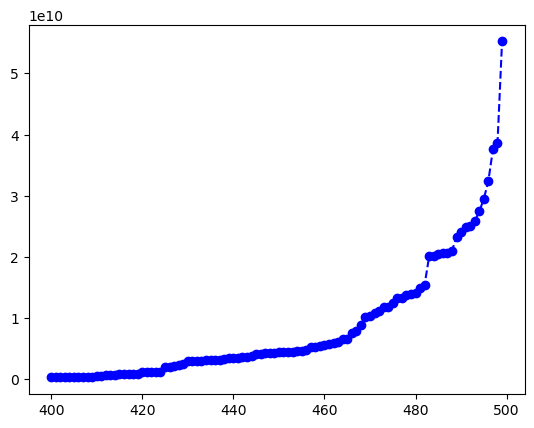

In [494]:
data = []
for key in fb_coflow_size.keys():
    data.append(fb_coflow_size[key])
sorted_coflow = sorted(data)
x = range(len(sorted_coflow))
plt.plot(x[400:500], sorted_coflow[400:500], 'bo--')

In [460]:
#sampling
numofCoflows = 40
#sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list = sampling(input_queue, input_data_flow, f_id_list, c_list, numofCoflows)
sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list, cid_flows = tight_sampling(input_queue, input_data_flow, f_id_list, c_list, numofCoflows, 350)
print("After sampling: ")
print(len(sample_c_list), " coflows, ", len(sample_f_id_list), " flows and ", len(sample_input_queue), " packets")

After sampling: 
40  coflows,  1342  flows and  111728  packets


In [461]:
for cid in sample_c_list:
    print(cid, ":", cid_flows[cid])

330.0 : 27
120.0 : 28
92.0 : 28
256.0 : 28
261.0 : 28
274.0 : 28
337.0 : 28
365.0 : 28
118.0 : 29
357.0 : 29
114.0 : 30
230.0 : 30
328.0 : 30
341.0 : 30
294.0 : 31
384.0 : 31
382.0 : 32
394.0 : 32
367.0 : 33
370.0 : 33
438.0 : 33
292.0 : 34
340.0 : 34
323.0 : 35
333.0 : 35
342.0 : 35
448.0 : 35
326.0 : 36
380.0 : 36
393.0 : 36
6.0 : 37
343.0 : 38
373.0 : 38
421.0 : 38
226.0 : 40
368.0 : 40
58.0 : 42
189.0 : 42
338.0 : 42
224.0 : 43


In [464]:
#grouping
switches=[]
numOfSwitches = 2
for i in range(numOfSwitches):
    switches.append(Switch())
#switches = fair_grouping(switches, sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list, numOfSwitches)

alpha = 0.8
switches = grouping_alpha(switches, sample_c_list, sample_f_id_list, sample_input_data_flow, alpha)
#switches = custom_grouping(switches, sample_c_list, sample_f_id_list, sample_input_data_flow)
#switches, shuffle_cid_list = grouping2(switches, sample_input_queue, sample_input_data_flow, sample_f_id_list, sample_c_list, numOfSwitches)
for switch in switches:
    print(len(switch.input_queue))

60818
50910


In [384]:
switch_cid = []
for switch in switches:
    tmp_set = set()
    for packet in switch.input_queue:
        tmp_set.add(packet[0])
    switch_cid.append(list(tmp_set))
for cid_list in switch_cid:
    print(cid_list)

[256.0, 384.0, 261.0, 6.0, 393.0, 394.0, 274.0, 292.0, 421.0, 294.0, 438.0, 58.0, 189.0, 448.0, 323.0, 326.0, 328.0, 330.0, 333.0, 337.0, 338.0, 340.0, 341.0, 342.0, 343.0, 92.0, 224.0, 226.0, 357.0, 230.0, 365.0, 367.0, 368.0, 114.0, 370.0, 373.0, 118.0, 120.0, 380.0, 382.0]
[256.0, 384.0, 261.0, 6.0, 393.0, 394.0, 274.0, 292.0, 421.0, 294.0, 438.0, 58.0, 189.0, 448.0, 323.0, 326.0, 328.0, 330.0, 333.0, 337.0, 338.0, 340.0, 341.0, 342.0, 343.0, 92.0, 224.0, 226.0, 357.0, 230.0, 365.0, 367.0, 368.0, 114.0, 370.0, 373.0, 118.0, 120.0, 380.0, 382.0]


In [465]:
global_reset()

In [466]:
counter=0
#mapping_counter=35000
packet_index=-1
while True:
    counter+=1
    packet_index+=1
    done=0
    for switch in switches:
        if counter >= len(switch.input_queue) and switch.wait_queue.qsize() == 0:
            done+=1
            continue
        if packet_index < len(switch.input_queue):
            this_packet = list(switch.input_queue[packet_index])
            if this_packet[0] not in current_global_coflow_size.keys():
                current_global_coflow_size[this_packet[0]] = this_packet[6]
            else:
                current_global_coflow_size[this_packet[0]] += this_packet[6]
            f_id = getFlowID(this_packet, sample_f_id_list)
            find, this_packet = checkPriorityTable(switch, f_id, this_packet)
            if not find:
                # Update Packet Count Table
                action = updatePacketCntTable(switch, f_id, this_packet)
            # Update Flow Size Table
            updateFlowSizeTable(switch, f_id, this_packet)
            # New flow or Packet full, inform controller
            if not find and action:
                updateFlowRecordTable(switches, switch, f_id, sample_c_list, this_packet)
            #print("flow record table: ", switch.flow_record_table)
            # Controller update
            if counter % CONTROLLER_UPDATE_TIME == 0 or packet_index == len(switch.input_queue)-1:
                switch.coflow_priority_table = controllerUpdate(switch, switches)
            #PIFO
            switch.wait_queue = PIFO(this_packet, switch.wait_queue)
            '''
            if current_global_coflow_size[real_cid]>=global_coflow_size[real_cid]/2 and real_cid not in priority_done:
                result = priority_assign(switches)
                print("Counter = ", counter)
                print("Priority assignment result = ", result)
                priority_result[counter] = [real_cid, result]
                priority_done.add(real_cid)
            '''
        # Egress
        if counter % (EGRESS_RATE*numOfSwitches) == 0:
            switch.output_queue = egress(switch)
        
        # Print Result
        if counter % 100 == 0:
            print("Switch ", switches.index(switch))
            print("Time slot: ", counter)
            print("len of wait queue: ", len(switch.wait_queue.queue))
        
        # Update TTL
        controllerUpdateTTL(switch, f_id)
    '''
    if done==0 and counter%20000==0:
        priority_assignment_with_mapping(switches)
    '''
    if done==numOfSwitches:
        break
print("All switches complete")

------  0  ------
sketch size:  4668.0  real size:  4668.0
sketch cnt:  20  real cnt:  20
sketch mean:  233.4  real mean:  233.4
-----------------
------  2  ------
sketch size:  4594.0  real size:  4594.0
sketch cnt:  20  real cnt:  20
sketch mean:  229.7  real mean:  229.7
-----------------
------  1  ------
sketch size:  4593.0  real size:  4593.0
sketch cnt:  20  real cnt:  20
sketch mean:  229.65  real mean:  229.65
-----------------
------  8  ------
sketch size:  4608.0  real size:  4608.0
sketch cnt:  20  real cnt:  20
sketch mean:  230.4  real mean:  230.4
-----------------
------  3  ------
sketch size:  4587.0  real size:  4587.0
sketch cnt:  20  real cnt:  20
sketch mean:  229.35  real mean:  229.35
-----------------
------  9  ------
sketch size:  4576.0  real size:  4576.0
sketch cnt:  20  real cnt:  20
sketch mean:  228.8  real mean:  228.8
-----------------
------  4  ------
sketch size:  4565.0  real size:  4565.0
sketch cnt:  20  real cnt:  20
sketch mean:  228.25  re

returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {6.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 6.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(58.0, 49655.0), (6.0, 119959.0)]
---Local priority calculation section---

6.0 's major queue: 6.0
Coflow estimation size(local)
{6.0: 50725.0}
Local coflow priority without mapping:
[(6.0, 50725.0)]
---End of Local priority calculation section---

---

returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {118.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 118.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(120.0, 76645.0), (6.0, 170864.0), (58.0, 447729.0), (118.0, 519377.0)]
---Local priority calculation section---

6.0 's major queue: 6.0
120.0 's major queue: 120.0
118.0 's major queue: 118.0
Coflow estimation size(local)
{6.0: 50725.0, 120.0: 32007.0, 118.0: 433624.0}
Local coflow priority without mapping:
[(120.0, 32007.0), (6.0, 50725.0), (118.0, 433624.0)]
---End of Local priority calculation section---

---Mapping priority calculation section---

6.0 's major queue: 6.0
local size= 50725.0
6.0 's ma

returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
returned cid result =  120.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {120.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 120.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (120.0, 246437.0), (58.0, 447729.0), (118.0, 1098147.0)]
---Local priority calculation section---

6.0 's major queue: 6.0
120.0 's major queue: 120.0
118.0 's major queue: 118.0
Coflow estimation size(local)
{6.0: 50725.0, 120.0: 80754.0, 118.0: 929368.0}
Local coflow priority without mapping:
[(6.0, 50725.0), (120.0, 80754.0), (118.0, 929368.0

returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {118.0: 15}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 118.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (120.0, 355021.0), (58.0, 447729.0), (118.0, 1747170.0)]
---Local priority calculation section---

6.0 's major queue: 6.0
120.0 's major queue: 120.0
118.0 's major queue: 118.0
Coflow estimation size(

returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {118.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 118.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (120.0, 445518.0), (58.0, 447729.0), (118.0, 2079207.0)]


returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
returned cid result =  6.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {6.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 6.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (92.0, 261490.0), (58.0, 447729.0), (120.0, 503478.0), (114.0, 560942.0), (118.0, 2811547.0)]
---Local priority calculation section---

6.0 's major queue: 6.0
120.0 's major queue: 120.0
118.0 's major queue: 118.0
114.0 's major queue: 114.0
Coflow estimation size(local)
{6.0: 50725.0, 120.0: 115530.0, 118.0: 2652012.0, 114.0: 47971.0}
Local coflow priority without mapping:
[(114.0, 47971.0), (6.0, 50725.0), (120.0, 115530.0), (118.0, 2652012.0)]
---End of Local priority calculation section---

---Map

returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {92.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 92.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1062775.0), (114.0, 1370245.0), (118.0, 2811547.0)]
---Local priority calculation section---

120.0 's major queue: 120.0
118.0 's major queue: 118.0
114.0 's major queue: 114

returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
returned cid result =  92.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {92.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 92.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(6.0, 170864.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1435931.0), (114.0, 1920809.0), (11

returned cid result =  114.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {114.0: 15}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 114.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(189.0, 5262.0), (6.0, 170864.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1579912.0), (114.0, 2676655.0), (118.0, 2811547.0)]
---Local priority calculation section---

120.0 's major queue: 120.0
118.0 's major queue: 118.0
114.0 's major queue: 114.0
92.0 's major queue: 92.0
Coflow estimation size(local)
{120.0: 115530.0, 118.0: 2652012.0, 114.0: 2026115.0, 92.0: 370632.0}
Local coflow priority without mapping:
[(120.0, 115530.0), (92.0, 370632.0), (114.0, 2026115.0), (118.0, 2652012.0)]
---End of Local priority calculation section---

---Mapping priority calculation section---

120.0 's major queue: 120.0
local

returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
returned cid result =  118.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {118.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 118.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 18374.0), (224.0, 47143.0), (6.0, 170864.0), (189.0, 176193.0), (230.0, 225650.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1579912.0), (118.0, 2811547.0), (114.0, 3656954.0)]
---Local priority calculation section---

120.0 's major queue: 120.0
118.0 's major queue: 118.0
114.0 's major queue: 114.0
92.0 's major queue: 92.0
Coflow estimation size(local)
{120.0: 115530.0, 118.0: 2652012.0, 114.0: 2989912.0, 92.0: 370632.0}
Local coflow priority without mapping:
[(120.0, 115530.0), (92.0, 370632

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 5}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
Switch  0
Time slot:  16200
len of wait queue:  14580
Switch  1
Time slot:  16200
len of wait queue:  14580
------  281  ------
sketch size:  3991.0  real size:  3991.0
sketch cnt:  20  real cnt:  20
sketch mean:  199.55  real mean:  199.55
-----------------
Switch  0
Time slot:  16300
len of wait queue:  14670
Switch  1
Time slot:  16300
len of wait queue:  14670
------  357  ------
sketch size:  16548.0  real size:  16548.0
sketch cnt:  20  real cnt:  20
sketch mean:  827.4  real mean:  827.4
-----------------
Switch  0
Time slot:  16400
len of wait queue:  14760
Switch  1
Time slot:  16400
len of wait queue:  14760
------  296  ------
sketch size:  7141.0  real size:

returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {230.0: 10}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 230.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 134065.0), (6.0, 170864.0), (189.0, 238545.0), (224.0, 262900.0), (58.0, 447729.0), (120.0, 503478.0), (230.0, 1072634.0), (92.0, 1579912.0), (256.0, 2441666.0), (118.0, 2811547.0), (114.0, 4194947.0)]
---Local priority calculation section---

120.0 's major queue: 120.0
118.0 's major queue: 118.0
114.0 's major queue: 114.0
92.0 's major queue: 92.0
22

returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  230.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
returned cid result =  261.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {261.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 2

returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {292.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 292.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(292.0, 53494.0), (294.0, 106053.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (274.0, 750190.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0)]
---Local priority calculation section---

114.0 's major queue: 114.0
226.0 's major queue: 226.0
230.0 's major queue: 230.0
256.0 's major queue: 256.0
294.0 's major queue: 294.0
261.0 's major queue: 261.0
292.0 's major 

returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {292.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 292.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(292.0, 109538.0), (294.0, 133936.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (274.0, 1413028.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0)]
---Local priority calculation section---

226.0 's major queue: 226.0
230.0 's major queue: 230.0
256.0 's major queue: 256.0
294.0 's major queue: 294.0
261.0 's major queue: 261.0
292.0 's major queue: 292.0
274.0 's majo

returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {292.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 292.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(292.0, 137704.0), (226.0, 148347.0), (294.0, 151595.0), (6.0, 170864.0), (189.0, 238545.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (274.0, 1517315.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 281

returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
returned cid result =  292.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {292.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 292.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 148347.0), (294.0, 170670.0), (6.0, 170864.0), (292.0, 172857.0), 

returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
returned cid result =  274.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {274.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 274.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(340.0, 14194.0), (333.0, 18967.0), (323.0, 88491.0), (226.0, 148347.0), (

returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {294.0: 15}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 294.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(340.0, 14194.0), (333.0, 47468.0), (323.0, 88491.0), (226.0, 148347.0), (6.0, 170864.0), (294.0, 184108.0), (292.0, 189657.0), (189.0, 238545.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (338.0, 1445939.

returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
returned cid result =  294.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {294.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 294.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(340.0, 14194.0), (326.0, 40270.0), (333.0, 66522.0), (226.0, 148347.0), (

returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {326.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 326.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(340.0, 42475.0), (333.0, 66522.0), (326.0, 138334.0), (226.0, 148347.0), (6.0, 170864.0), (323.0, 194770.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1579912.0), (338.0, 1796773.0), (230.0, 1850155.0), (118.0, 2811547.0), (274.0, 3471917.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0)]
---Local priority calculation section---

230.0 's major queue: 230.0
256.0 's major queue: 256.0
294.0 's major queue: 294.0
261

returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {340.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 340.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 66522.0), (340.0, 97191.0), (226.0, 148347.0), (6.0, 170864.0), (323.0, 194770.0), (326.0, 221475.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (338.0, 2887872.0), (274.0, 3471917.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0)]
---Local priority calculation section---

256.0 's major queue: 256.0
294.0 's major queue: 294.0
261.0 's major queue: 261.0
292

returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {340.0: 10}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 340.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 85509.0), (226.0, 148347.0), (340.0, 167984.0), (6.0, 170864.0), (323.0, 212467.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (326.0, 281887.0), (224.0, 289901.0), (58.0, 447729.0), (120.0, 503478.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (274.0, 3471917.0), (338.0, 3535414.0), (114.0, 4194947.0), (256.0, 4535386.0), (

returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {338.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 338.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 132938.0), (226.0, 148347.0), (6.0, 170864.0), (340.0, 226466.0), (189.0, 238545.0), (292.0, 238897.0), (323.0, 265540.0), (294.0, 278120.0), (224.0, 289901.0), (326.0, 402739.0), (58.0, 447729.0), (337.0, 49958

returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {340.0: 15}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 340.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 132938.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), (340.0, 238764.0), (292.0, 238897.0), (323.0, 265540.0), (294.0, 278120.0), (224.0, 289901.0), (326.0, 402739.0), (58.0, 447729.0), (120.0, 50347

returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {340.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 340.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 132938.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), 

returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {338.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 338.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(333.0, 142404.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (340.0, 311387.0), (323.0, 354003.0), (58.0, 447729.0), (120.0, 503478.0), (326.0, 563844.0), (337.0, 1061177.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (274.0, 3471917.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0), (338.0, 5093571.0)]
---Local priority calculation section---

294.0 's major queue: 294.0
261.0 's major queue: 261.0
292.0 's 

returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {326.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 326.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 148347.0), (333.0, 151868.0), (6.0, 170864.0), (189.0, 238545.0), 

returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
returned cid result =  326.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {326.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 326.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 148347.0), (6.0, 170864.0), (333.0, 199362.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (340.0, 410607.0), (323.0, 442586.0), (58.0, 447729.0), (120.0, 503478.0), (328.0, 582804.0), (326.0, 722269.0), (337.0, 1061177.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (274.0, 3471917.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0), (338.0, 7061929.0)]
---Local priority calculation section---

294.0 's major queue: 294.0
292.0 's major que

returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {337.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 337.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(226.0, 148347.0), (6.0, 170864.0), (333.0, 227917.0), (189.0, 238545.0), (292.0, 238897.0), (330.0, 240465.0), (294.0, 278120.0), (224.0, 289901.0), (340.0, 410607.0), (323.0, 442586.0), (58.0, 447729.0), (120.0, 503478.0), (326.0, 724893.0), (328.0, 1456278.0), (92.0, 1579912.0), (337.0, 1829440.0), (230.0, 1850155.0), (118.0, 2811547.0), (274.0, 3471917.0), (114.0, 4194947.0), (256.0, 4535386.0), (261.0, 4789925.0), (338.0, 7565259.0)]
---Local priority calculation section---

294.0 's major queue: 294.

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 20}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
Switch  0
Time slot:  39300
len of wait queue:  35370
Switch  1
Time slot:  39300
len of wait queue:  35370
------  755  ------
sketch size:  10164.0  real size:  10164.0
sketch cnt:  20  real cnt:  20
sketch mean:  508.2  real mean:  508.2
-----------------
Switch  0
Time slot:  39400

returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {337.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 337.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(357.0, 20200.0), (341.0, 20548.0), (343.0, 22303.0), (342.0, 30405.0), (226.0, 148347.0), (6.0, 170864.0), (333.0, 227917.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (330.0, 379909.0), (323.0, 442586.0), (58.0, 447729.0), (340.0, 453004.0), (120.0, 503478.0), (326.0, 724893.0), (92.0, 1579912.0), (230.0, 1850155.0), (328.0, 2

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 10}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  809  ------
sketch size:  9650.0  real size:  9650.0
sketch cnt:  20  real cnt:  20
sketch mean:  482.5  real mean:  482.5
-----------------
Switch  0
Time slot:  40500
len of wait queue:  36450
Switch  1
Time slot:  40500
len of wait queue:  36450
------  810  ------
sketch size:  10108.0  real size:  10108.0
sketch cnt:  20  real cnt:  20
sketch mean:  505.4  real mean:  505.4
-----------------
------  812  ------
sketch size:  10121.0  real size:  10121.0
sketch cnt:  20  real cnt:  20
sketch mean:  506.05  real mean:  506.05
---

returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
returned cid result =  337.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {337.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 337.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(341.0, 34152.0), (342.0, 77185.0), (357.0, 134730.0), (226.0, 148347.0), (6.0, 170864.0), (343.0, 212002.0), (189.0, 238545.0), (292.0, 238897.0), (333.0, 246910.0), (294.0, 278120.0), (224.0, 289901.0), (330.0, 379909

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 20}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  867  ------
sketch size:  5862.0  real size:  5862.0
sketch cnt:  20  real cnt:  20
sketch mean:  293.1  real mean:  293.1
-----------------
------  868  ------
sketch size:  5940.0  real size:  5940.0
sketch cnt:  20  real cnt:  20
sketch mean:  297.0  real mean:  297.0
-----------------
---Beginning of Mapping---
local coflow distribution (switch  1 ): 
326.0 :  {326.0: 31}
340.0 :  {340.0: 26}
338.0 :  {338.0: 7}
337.0 :  {337.0: 5}
328.0 :  {328.0: 22}

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 5}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  939  ------
sketch size:  2256.0  real size:  2256.0
sketch cnt:  20  real cnt:  20
sketch mean:  112.8  real mean:  112.8
-----------------
------  940  ------
sketch size:  12191.0  real size:  12191.0
sketch cnt:  20  real cnt:  20
sketch mean:  609.55  real mean:  609.55
-----------------
Switch  0
Time slot:  42200
len of wait queue:  37980
Switch  1
Time slot:  42200
len of wait queue:  37980
Switch  0
Time slot:  42300
len of wait queue:  38070
Switch  1
Time slot:  42300
len of wait queue:  38070
------  648  ------
sketch size:  17951.0  real size:  17951.0
sketch cnt:  20  real cnt:  20
sketch mean:  897.55  real mean:  897.55
-----------------
---Begi

returned cid result =  338.0
returned cid result =  338.0
returned cid result =  340.0
returned cid result =  338.0
returned cid result =  340.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {338.0: 3, 340.0: 2}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 338.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 4733.0), (373.0, 13093.0), (384.0, 14630.0), (365.0, 14854.0), (367.0, 18288.0), (380.0, 42761.0), (341.0, 54684.0), (368.0, 73234.0), (342.0, 123504.0), (226.0, 148347.0), (6.0, 170864.0), (357.0, 211728.0), (189.0, 238545.0), (292.0, 238897.0), (333.0, 259404.0), (294.0, 278120.0), (224.0, 289901.0), (343.0, 334736.0), (330.0, 379909.0), (58.0, 447729.0), (340.0, 467157.0), (120.0, 503478.0), (382.0, 553053.0), (323.0, 584086.0), (326.0, 724893.0), (92.0, 1579912.0), (230.0, 1850155.0),

returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  338.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {338.0: 7, 340.0: 3}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 338.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 4733.0), (373.0, 13093.0), (384.0, 14630.0), (365.0, 14854.0), (367.0, 18288.0), (341.0, 54684.0), (368.0, 73234.0), (380.0, 96111.0), (342.0, 123504.0), (226.0, 148347.0), (6.0, 170864.0), (357.0, 211728.0), (189.0, 238545.0), (292.0, 238897.0), (333.0, 275385.0), (294.0, 278120.0), (224.0, 289901.0), (343.0, 334736.0), (330.0, 379909.0), (58.0

returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
returned cid result =  338.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {338.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 338.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 4733.0), (384.0, 14630.0), (365.0, 14854.0), (373.0, 15583.0), (367.0, 18288.0), (341.0, 54684.

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 5}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  984  ------
sketch size:  2200.0  real size:  2200.0
sketch cnt:  20  real cnt:  20
sketch mean:  110.0  real mean:  110.0
-----------------
Switch  0
Time slot:  45000
len of wait queue:  40500
Switch  1
Time slot:  45000
len of wait queue:  40500
------  985  ------
sketch size:  5611.0  real size:  5611.0
sketch cnt:  20  real cnt:  20
sketch mean:  280.55  real mean:  280.55
-----------------
------  986  ------
sketch size:  5641.0  real size:  5641.0
sketch cnt:  20  real cnt:  20
sketch mean:  282.05  real mean:  282.05
-----------------
------  989  ------
sketch size:  10671.0  real size:  10671.0
sketch cnt:  20  real cnt:  20
sketch mean:  533.55  rea

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 15}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
Switch  0
Time slot:  45600
len of wait queue:  41040
Switch  1
Time slot:  45600
len of wait queue:  41040
------  1037  ------
sketch size:  3384.0  real size:  3384.0
sketch cnt:  20  real cnt:  20
sketch mean:  169.2  real mean:  169.2
-----------------
------  1038  ------
sketch size:  2174.0  real size:  2174.0
sketch cnt:  20  real cnt:  20
sketch mean:  108.7  real mean:  108.7
-----------------
------  1041  ------
sketch size:  2222.0  real size:  2222.0
sketch cnt:  20  real cnt:  20
sketch mean:  111.1

returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
returned cid result =  340.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {340.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 340.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(384.0, 29265.0), (370.0, 32411.0), (373.0, 38361.0), (341.0, 54684.0), (3

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 20}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  1066  ------
sketch size:  12183.0  real size:  12183.0
sketch cnt:  20  real cnt:  20
sketch mean:  609.15  real mean:  609.15
-----------------
------  1067  ------
sketch size:  12192.0  real size:  12192.0
sketch cnt:  20  real cnt:  20
sketch mean:  609.6  real mean:  609.

returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {328.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 328.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(384.0, 29265.0), (370.0, 32411.0), (373.0, 38361.0), (341.0, 54684.0), (367.0, 58670.0), (365.0, 59467.0), (342.0, 123504.0), (226.0, 148347.0), (368.0, 154539.0), (6.0, 170864.0), (357.0, 211728.0), (380.0, 213525.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (333.0, 313429.0), (343.0, 334736.0), (330.0, 379909.0), (58.0, 447729.0), (340.0, 467157.0), (120.0, 503478.0), (323.0, 619514.0), (326.0, 724893.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (382.

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 5}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  1097  ------
sketch size:  10633.0  real size:  10633.0
sketch cnt:  20  real cnt:  20
sketch mean:  531.65  real mean:  531.65
-----------------
Switch  0
Time slot:  48300
len of wait queue:  43470
Switch  1
Time slot:  48300
len of wait queue:  43470
------  1098  ------
sketch size:  10716.0  real size:  10716.0
sketch cnt:  20  real cnt:  20
sketch mean:  535.8  real mean:  535.8
-----------------
Switch  0
Time slot:  48400
len of wait queue:  43560
Switch  1
Time slot:  48400
len of wait queue:  43560
------  1112  ------
sketch size:  3282.0  real size:  3282.0
sketch cnt:  20  real cnt:  20
sketch mean:  164.1  real mean:  164.1
-----------------
---Beg

returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {328.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 328.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(384.0, 43933.0), (370.0, 49633.0), (341.0, 54684.0), (373.0, 66956.0), (365.0, 72972.0), (367.0, 85847.0), (342.0, 123504.0), (226.0, 148347.0), (6.0, 170864.0), (357.0, 211728.0), (368.0, 219744.0), (189.0, 238545.0), (292.0, 238897.0), (380.0, 277581.0), (294.0, 278120.0), (224.0, 289901.0), (333.0, 313429.0), (343.0, 334736.0), (58.0, 447729.0), (340.0, 467157.0), (120.0, 503478.0), (323.0, 619514.0), (330.0, 707656.0), (326.0, 724893.0), (92.0, 1579912.0), (230.0, 1850155.0), (118.0, 2811547.0), (382.

returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
returned cid result =  330.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {330.0: 20}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 330.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(384.0, 51251.0), (341.0, 54684.0), (370.0, 56650.0), (373.0, 66956.0), (3

returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
returned cid result =  328.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {328.0: 5}
---End of single queue mapping---

Local switch id: 1
Remote switch id: 0
Remote queue id: 328.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (341.0, 54684.0), (370.0, 56650.0), (373.0, 77174.0), (365.0, 89175.0), (394.0, 96695.0), (367.0, 100491.0), (342.0, 123504.0), (226.0, 148347.0), (6.0, 170864.0), (357.0, 211728.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 244148.0), (294.0, 278120.0), (224.0, 289901.0), (333.0, 313429.0), (380.0, 320248.0), (343.0, 334736.0), (58.0, 447729.0), (340.0, 467157.0), (120.0, 503478.0), (323.0, 619514.0), (326.0, 724893.0), (330.0, 1014779.0), (92.0, 1579912.0), (230.0,

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 10}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  1282  ------
sketch size:  9634.0  real size:  9634.0
sketch cnt:  20  real cnt:  20
sketch mean:  481.7  real mean:  481.7
-----------------
------  724  ------
sketch size:  10215.0  real size:  10215.0
sketch cnt:  20  real cnt:  20
sketch mean:  510.75  real mean:  510.75
-----------------
------  1283  ------
sketch size:  9628.0  real size:  9628.0
sketch cnt:  20  real cnt:  20
sketch mean:  481.4  real mean:  481.4
-----------------
------  1284  ------
sketch size:  9634.0  real size:  9634.0
sketch cnt:  20  real cnt:  20


returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  330.0
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 19, 330.0: 1}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
------  1305  ------
sketch size:  9625.0  real size:  9625.0
sketch cnt:  20  real cnt:  20
sketch mean:  481.25  real mean:  481.25
-----------------
------  1306  ------
sketch size:  9633.0  real size:  9633.0
sketch cnt:  20  real cnt:  20
sketch mean:  481.65  real m

------  749  ------
sketch size:  13567.0  real size:  13567.0
sketch cnt:  20  real cnt:  20
sketch mean:  678.35  real mean:  678.35
-----------------
Switch  0
Time slot:  52600
len of wait queue:  47340
Switch  1
Time slot:  52600
len of wait queue:  45650
Switch  0
Time slot:  52700
len of wait queue:  47430
Switch  1
Time slot:  52700
len of wait queue:  45640
Switch  0
Time slot:  52800
len of wait queue:  47520
Switch  1
Time slot:  52800
len of wait queue:  45630
------  750  ------
sketch size:  10261.0  real size:  10261.0
sketch cnt:  20  real cnt:  20
sketch mean:  513.05  real mean:  513.05
-----------------
Switch  0
Time slot:  52900
len of wait queue:  47610
Switch  1
Time slot:  52900
len of wait queue:  45620
------  751  ------
sketch size:  10204.0  real size:  10204.0
sketch cnt:  20  real cnt:  20
sketch mean:  510.2  real mean:  510.2
-----------------
---Beginning of Mapping---
local coflow distribution (switch  0 ): 
338.0 :  {338.0: 35}
340.0 :  {340.0: 7}
32

returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {421.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 421.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (341.0, 75154.0), (373.0, 77174.0), (365.0, 89175.0), (448.0, 98455.0), (367.0, 100491.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (342.0, 194868.0), (357.0, 211728.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 244148.0), (294.0, 278120.0), (224.0, 289901.0), (438.0, 313510.0), (380.0, 320248.0), (333.0, 332479.0), (343.0, 345893.0), (421.0, 423658.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (323.0, 619514.0), (326.0, 

returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {384.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 384.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (373.0, 77174.0), (365.0, 89175.0), (448.0, 98455.0), (367.0, 100491.0), (341.0, 115965.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 244148.0), (342.0, 246980.0), (357.0, 257792.0), (294.0, 278120.0), (224.0, 289901.0), (438.0, 313510.0), (380.0, 320248.0), (333.0, 332479.0), (343.0, 357044.0), (421.0, 423658.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (323.0, 619514.0), (326.0,

returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {421.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 421.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (373.0, 77174.0), (365.0, 89175.0), (448.0, 98455.0), (367.0, 100491.0), (394.0, 125414.0), (341.0, 129567.0), (226.0, 148347.0), (6.0, 170864.0), (189.0, 238545.0),

returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {421.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 421.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (373.0, 77174.0), (3

returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {421.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 421.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (373.0, 77174.0), (3

returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {384.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 384.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (384.0, 51251.0), (370.0, 56650.0), (373.0, 77174.0), (365.0, 89175.0), (448.0, 98455.0), (367.0, 100491.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 244148.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 308119.0), (438.0, 313510.0), (380.0, 320248.0), (333.0, 332

returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {384.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 384.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 66039.0), (373.0, 77174.0), (384.0, 86137.0), (448.0, 98455.0), (367.0, 107831.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (365.0, 178348.0), (341.0, 204601.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 252313.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 312186.0), (438.0, 313510.0), (380.0, 330945.0), (333.0, 332479.0), (421.0, 423658.0), (343.0, 423994.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (342.0, 540391.0), (323.0, 619514.0), (326.0

returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
returned cid result =  365.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {365.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 365.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 68345.0), (373.0, 84681.0), (448.0, 98455.0), (367.0, 107831.0), (384.0, 109787.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (365.0, 236459.0), (189.0, 238545.0), (292.0, 238897.0), (368.0, 260436.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 312186.0), (438.0, 313510.0), (333.0, 332479.0), (380.0, 3

returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
returned cid result =  384.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {384.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 384.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 72865.0), (373.0, 87236.0), (448.0, 98455.0), (367.0, 107831.0), (384.0, 122746.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (368.0, 284915.0), (224.0, 289901.0), (365.0, 312135.0), (357.0, 312186.0), (438.0, 313510.0), (333.0, 332479.0), (380.0, 3

returned cid result =  382.0
returned cid result =  382.0
returned cid result =  382.0
returned cid result =  382.0
returned cid result =  382.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {382.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 382.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 72865.0), (373.0, 87236.0), (448.0, 98455.0), (367.0, 107831.0), (394.0, 125414.0), (226.0, 148347.0), (384.0, 161041.0), (6.0, 170864.0), (341.0, 204601.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (368.0, 284915.0), (224.0, 289901.0), (365.0, 312135.0), (357.0, 312186.0), (438.0, 313510.0), (333.0, 332479.0), (380.0, 362951.0), (421.0, 423658.0), (343.0, 423994.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (342.0, 540391.0), (323.0, 619514.0), (326.

returned cid result =  380.0
returned cid result =  380.0
returned cid result =  380.0
returned cid result =  380.0
returned cid result =  380.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {380.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 380.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 75216.0), (373.0, 89748.0), (448.0, 98455.0), (367.0, 111571.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (384.0, 197673.0), (341.0, 204601.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (368.0, 293063.0), (357.0, 312186.0), (438.0, 313510.0), (333.0, 332479.0), (365.0, 356733.0), (380.0, 373625.0), (421.0, 423658.0), (343.0, 423994.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (342.0, 540391.0), (323.0, 619514.0), (326.

returned cid result =  367.0
returned cid result =  367.0
returned cid result =  367.0
returned cid result =  367.0
returned cid result =  367.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {367.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 367.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(393.0, 40432.0), (370.0, 77494.0), (373.0, 94732.0), (448.0, 98455.0), (367.0, 118582.0), (394.0, 125414.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (384.0, 219635.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 312186.0), (438.0, 313510.0), (368.0, 317469.0), (333.0, 332479.0), (380.0, 384295.0), (365.0, 416200.0), (421.0, 423658.0), (343.0, 423994.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (342.0, 540391.0), (323.0, 619514.0), (326.

returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
classified = 5 , fid not found = 0 , packet count equal zero = 0
current result =  {394.0: 5}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 394.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 77494.0), (373.0, 97251.0), (448.0, 98455.0), (367.0, 122507.0), (226.0, 148347.0), (393.0, 161882.0), (6.0, 170864.0), (341.0, 204601.0), (394.0, 222152.0), (384.0, 226943.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 312186.0), (438.0, 313510.0), (368.0, 325621.0), (333.0, 332479.0), (380.0, 384295.0), (365.0, 416200.0), (421.0, 423658.0), (343.0, 423994.0), (58.0, 447729.0), (340.0, 481255.0), (120.0, 503478.0), (342.0, 540391.0), (323.0, 619514.0), (326

returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
classified = 10 , fid not found = 0 , packet count equal zero = 0
current result =  {394.0: 10}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 394.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 77494.0), (373.0, 97251.0), (448.0, 98455.0), (367.0, 122507.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (393.0, 215788.0), (384.0, 226943.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.0), (357.0, 312186.0), (438.0, 313510.0), (368.0, 325621.0), (394.0, 326772.0), (333.0, 332479.0), (380.0, 384295.0), (365.0, 

returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
returned cid result =  394.0
classified = 15 , fid not found = 0 , packet count equal zero = 0
current result =  {394.0: 15}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 394.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 77494.0), (373.0, 97251.0), (448.0, 98455.0), (367.0, 122507.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (384.0, 226943.0), (189.0, 238545.0), (292.0, 238897.0), (294.0, 278120.0), (224.0, 289901.

returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
returned cid result =  421.0
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {421.0: 20}
---End of single queue mapping---

Local switch id: 0
Remote switch id: 1
Remote queue id: 421.0
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 77494.0), (373.0, 97251.0), (448.0, 98455.0), (367.0, 122507.0), (

returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
returned cid result =  -1
classified = 20 , fid not found = 0 , packet count equal zero = 0
current result =  {-1: 20}
---End of single queue mapping---

No mapping queue found, exit mapping process
---End of Mapping---
---Coflow size estimation record section---
---Local Priority assignment section---

Global coflow size in the order of priority : [(370.0, 77494.0), (373.0, 97251.0), (448.0, 98455.0), (367.0, 122507.0), (226.0, 148347.0), (6.0, 170864.0), (341.0, 204601.0), (384.0, 226943.0), (189.0,

Switch  0
Time slot:  61000
len of wait queue:  54718
Switch  1
Time slot:  61000
len of wait queue:  44810
Switch  0
Time slot:  61100
len of wait queue:  54708
Switch  1
Time slot:  61100
len of wait queue:  44800
Switch  0
Time slot:  61200
len of wait queue:  54698
Switch  1
Time slot:  61200
len of wait queue:  44790
Switch  0
Time slot:  61300
len of wait queue:  54688
Switch  1
Time slot:  61300
len of wait queue:  44780
Switch  0
Time slot:  61400
len of wait queue:  54678
Switch  1
Time slot:  61400
len of wait queue:  44770
Switch  0
Time slot:  61500
len of wait queue:  54668
Switch  1
Time slot:  61500
len of wait queue:  44760
Switch  0
Time slot:  61600
len of wait queue:  54658
Switch  1
Time slot:  61600
len of wait queue:  44750
Switch  0
Time slot:  61700
len of wait queue:  54648
Switch  1
Time slot:  61700
len of wait queue:  44740
Switch  0
Time slot:  61800
len of wait queue:  54638
Switch  1
Time slot:  61800
len of wait queue:  44730
Switch  0
Time slot:  61900


Switch  0
Time slot:  69600
len of wait queue:  53858
Switch  1
Time slot:  69600
len of wait queue:  43950
Switch  0
Time slot:  69700
len of wait queue:  53848
Switch  1
Time slot:  69700
len of wait queue:  43940
Switch  0
Time slot:  69800
len of wait queue:  53838
Switch  1
Time slot:  69800
len of wait queue:  43930
Switch  0
Time slot:  69900
len of wait queue:  53828
Switch  1
Time slot:  69900
len of wait queue:  43920
Switch  0
Time slot:  70000
len of wait queue:  53818
Switch  1
Time slot:  70000
len of wait queue:  43910
Switch  0
Time slot:  70100
len of wait queue:  53808
Switch  1
Time slot:  70100
len of wait queue:  43900
Switch  0
Time slot:  70200
len of wait queue:  53798
Switch  1
Time slot:  70200
len of wait queue:  43890
Switch  0
Time slot:  70300
len of wait queue:  53788
Switch  1
Time slot:  70300
len of wait queue:  43880
Switch  0
Time slot:  70400
len of wait queue:  53778
Switch  1
Time slot:  70400
len of wait queue:  43870
Switch  0
Time slot:  70500


len of wait queue:  48848
Switch  1
Time slot:  119700
len of wait queue:  38940
Switch  0
Time slot:  119800
len of wait queue:  48838
Switch  1
Time slot:  119800
len of wait queue:  38930
Switch  0
Time slot:  119900
len of wait queue:  48828
Switch  1
Time slot:  119900
len of wait queue:  38920
Switch  0
Time slot:  120000
len of wait queue:  48818
Switch  1
Time slot:  120000
len of wait queue:  38910
Switch  0
Time slot:  120100
len of wait queue:  48808
Switch  1
Time slot:  120100
len of wait queue:  38900
Switch  0
Time slot:  120200
len of wait queue:  48798
Switch  1
Time slot:  120200
len of wait queue:  38890
Switch  0
Time slot:  120300
len of wait queue:  48788
Switch  1
Time slot:  120300
len of wait queue:  38880
Switch  0
Time slot:  120400
len of wait queue:  48778
Switch  1
Time slot:  120400
len of wait queue:  38870
Switch  0
Time slot:  120500
len of wait queue:  48768
Switch  1
Time slot:  120500
len of wait queue:  38860
Switch  0
Time slot:  120600
len of wai

Switch  0
Time slot:  173900
len of wait queue:  43428
Switch  1
Time slot:  173900
len of wait queue:  33520
Switch  0
Time slot:  174000
len of wait queue:  43418
Switch  1
Time slot:  174000
len of wait queue:  33510
Switch  0
Time slot:  174100
len of wait queue:  43408
Switch  1
Time slot:  174100
len of wait queue:  33500
Switch  0
Time slot:  174200
len of wait queue:  43398
Switch  1
Time slot:  174200
len of wait queue:  33490
Switch  0
Time slot:  174300
len of wait queue:  43388
Switch  1
Time slot:  174300
len of wait queue:  33480
Switch  0
Time slot:  174400
len of wait queue:  43378
Switch  1
Time slot:  174400
len of wait queue:  33470
Switch  0
Time slot:  174500
len of wait queue:  43368
Switch  1
Time slot:  174500
len of wait queue:  33460
Switch  0
Time slot:  174600
len of wait queue:  43358
Switch  1
Time slot:  174600
len of wait queue:  33450
Switch  0
Time slot:  174700
len of wait queue:  43348
Switch  1
Time slot:  174700
len of wait queue:  33440
Switch  0


Switch  0
Time slot:  223200
len of wait queue:  38498
Switch  1
Time slot:  223200
len of wait queue:  28590
Switch  0
Time slot:  223300
len of wait queue:  38488
Switch  1
Time slot:  223300
len of wait queue:  28580
Switch  0
Time slot:  223400
len of wait queue:  38478
Switch  1
Time slot:  223400
len of wait queue:  28570
Switch  0
Time slot:  223500
len of wait queue:  38468
Switch  1
Time slot:  223500
len of wait queue:  28560
Switch  0
Time slot:  223600
len of wait queue:  38458
Switch  1
Time slot:  223600
len of wait queue:  28550
Switch  0
Time slot:  223700
len of wait queue:  38448
Switch  1
Time slot:  223700
len of wait queue:  28540
Switch  0
Time slot:  223800
len of wait queue:  38438
Switch  1
Time slot:  223800
len of wait queue:  28530
Switch  0
Time slot:  223900
len of wait queue:  38428
Switch  1
Time slot:  223900
len of wait queue:  28520
Switch  0
Time slot:  224000
len of wait queue:  38418
Switch  1
Time slot:  224000
len of wait queue:  28510
Switch  0


Switch  0
Time slot:  276700
len of wait queue:  33148
Switch  1
Time slot:  276700
len of wait queue:  23240
Switch  0
Time slot:  276800
len of wait queue:  33138
Switch  1
Time slot:  276800
len of wait queue:  23230
Switch  0
Time slot:  276900
len of wait queue:  33128
Switch  1
Time slot:  276900
len of wait queue:  23220
Switch  0
Time slot:  277000
len of wait queue:  33118
Switch  1
Time slot:  277000
len of wait queue:  23210
Switch  0
Time slot:  277100
len of wait queue:  33108
Switch  1
Time slot:  277100
len of wait queue:  23200
Switch  0
Time slot:  277200
len of wait queue:  33098
Switch  1
Time slot:  277200
len of wait queue:  23190
Switch  0
Time slot:  277300
len of wait queue:  33088
Switch  1
Time slot:  277300
len of wait queue:  23180
Switch  0
Time slot:  277400
len of wait queue:  33078
Switch  1
Time slot:  277400
len of wait queue:  23170
Switch  0
Time slot:  277500
len of wait queue:  33068
Switch  1
Time slot:  277500
len of wait queue:  23160
Switch  0


Switch  0
Time slot:  328800
len of wait queue:  27938
Switch  1
Time slot:  328800
len of wait queue:  18030
Switch  0
Time slot:  328900
len of wait queue:  27928
Switch  1
Time slot:  328900
len of wait queue:  18020
Switch  0
Time slot:  329000
len of wait queue:  27918
Switch  1
Time slot:  329000
len of wait queue:  18010
Switch  0
Time slot:  329100
len of wait queue:  27908
Switch  1
Time slot:  329100
len of wait queue:  18000
Switch  0
Time slot:  329200
len of wait queue:  27898
Switch  1
Time slot:  329200
len of wait queue:  17990
Switch  0
Time slot:  329300
len of wait queue:  27888
Switch  1
Time slot:  329300
len of wait queue:  17980
Switch  0
Time slot:  329400
len of wait queue:  27878
Switch  1
Time slot:  329400
len of wait queue:  17970
Switch  0
Time slot:  329500
len of wait queue:  27868
Switch  1
Time slot:  329500
len of wait queue:  17960
Switch  0
Time slot:  329600
len of wait queue:  27858
Switch  1
Time slot:  329600
len of wait queue:  17950
Switch  0


Switch  0
Time slot:  379400
len of wait queue:  22878
Switch  1
Time slot:  379400
len of wait queue:  12970
Switch  0
Time slot:  379500
len of wait queue:  22868
Switch  1
Time slot:  379500
len of wait queue:  12960
Switch  0
Time slot:  379600
len of wait queue:  22858
Switch  1
Time slot:  379600
len of wait queue:  12950
Switch  0
Time slot:  379700
len of wait queue:  22848
Switch  1
Time slot:  379700
len of wait queue:  12940
Switch  0
Time slot:  379800
len of wait queue:  22838
Switch  1
Time slot:  379800
len of wait queue:  12930
Switch  0
Time slot:  379900
len of wait queue:  22828
Switch  1
Time slot:  379900
len of wait queue:  12920
Switch  0
Time slot:  380000
len of wait queue:  22818
Switch  1
Time slot:  380000
len of wait queue:  12910
Switch  0
Time slot:  380100
len of wait queue:  22808
Switch  1
Time slot:  380100
len of wait queue:  12900
Switch  0
Time slot:  380200
len of wait queue:  22798
Switch  1
Time slot:  380200
len of wait queue:  12890
Switch  0


Switch  0
Time slot:  429500
len of wait queue:  17868
Switch  1
Time slot:  429500
len of wait queue:  7960
Switch  0
Time slot:  429600
len of wait queue:  17858
Switch  1
Time slot:  429600
len of wait queue:  7950
Switch  0
Time slot:  429700
len of wait queue:  17848
Switch  1
Time slot:  429700
len of wait queue:  7940
Switch  0
Time slot:  429800
len of wait queue:  17838
Switch  1
Time slot:  429800
len of wait queue:  7930
Switch  0
Time slot:  429900
len of wait queue:  17828
Switch  1
Time slot:  429900
len of wait queue:  7920
Switch  0
Time slot:  430000
len of wait queue:  17818
Switch  1
Time slot:  430000
len of wait queue:  7910
Switch  0
Time slot:  430100
len of wait queue:  17808
Switch  1
Time slot:  430100
len of wait queue:  7900
Switch  0
Time slot:  430200
len of wait queue:  17798
Switch  1
Time slot:  430200
len of wait queue:  7890
Switch  0
Time slot:  430300
len of wait queue:  17788
Switch  1
Time slot:  430300
len of wait queue:  7880
Switch  0
Time slot

Switch  0
Time slot:  481900
len of wait queue:  12628
Switch  1
Time slot:  481900
len of wait queue:  2720
Switch  0
Time slot:  482000
len of wait queue:  12618
Switch  1
Time slot:  482000
len of wait queue:  2710
Switch  0
Time slot:  482100
len of wait queue:  12608
Switch  1
Time slot:  482100
len of wait queue:  2700
Switch  0
Time slot:  482200
len of wait queue:  12598
Switch  1
Time slot:  482200
len of wait queue:  2690
Switch  0
Time slot:  482300
len of wait queue:  12588
Switch  1
Time slot:  482300
len of wait queue:  2680
Switch  0
Time slot:  482400
len of wait queue:  12578
Switch  1
Time slot:  482400
len of wait queue:  2670
Switch  0
Time slot:  482500
len of wait queue:  12568
Switch  1
Time slot:  482500
len of wait queue:  2660
Switch  0
Time slot:  482600
len of wait queue:  12558
Switch  1
Time slot:  482600
len of wait queue:  2650
Switch  0
Time slot:  482700
len of wait queue:  12548
Switch  1
Time slot:  482700
len of wait queue:  2640
Switch  0
Time slot

Time slot:  546900
len of wait queue:  6128
Switch  0
Time slot:  547000
len of wait queue:  6118
Switch  0
Time slot:  547100
len of wait queue:  6108
Switch  0
Time slot:  547200
len of wait queue:  6098
Switch  0
Time slot:  547300
len of wait queue:  6088
Switch  0
Time slot:  547400
len of wait queue:  6078
Switch  0
Time slot:  547500
len of wait queue:  6068
Switch  0
Time slot:  547600
len of wait queue:  6058
Switch  0
Time slot:  547700
len of wait queue:  6048
Switch  0
Time slot:  547800
len of wait queue:  6038
Switch  0
Time slot:  547900
len of wait queue:  6028
Switch  0
Time slot:  548000
len of wait queue:  6018
Switch  0
Time slot:  548100
len of wait queue:  6008
Switch  0
Time slot:  548200
len of wait queue:  5998
Switch  0
Time slot:  548300
len of wait queue:  5988
Switch  0
Time slot:  548400
len of wait queue:  5978
Switch  0
Time slot:  548500
len of wait queue:  5968
Switch  0
Time slot:  548600
len of wait queue:  5958
Switch  0
Time slot:  548700
len of wa

In [467]:
avg1 = []
avg2 = []
for key in partial_accuracy_improvement:
    print(partial_accuracy_improvement[key])
    if partial_accuracy_improvement[key][0] != 0:
        avg1.append(partial_accuracy_improvement[key][0])
    if partial_accuracy_improvement[key][1] != 0:
        avg2.append(partial_accuracy_improvement[key][1])
print(sum(avg1)/len(avg1))
print(sum(avg2)/len(avg2))

[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, -16.666666666666664]
[0.0, -16.666666666666664]
[0.0, -16.666666666666664]
[0.0, 0.0]
[16.666666666666664, 0.0]
[16.666666666666664, 0.0]
[33.33333333333333, 22.222222222222218]
[33.33333333333333, 22.222222222222218]
[44.44444444444444, 22.222222222222218]
[60.0, 20.0]
[83.33333333333334, 16.666666666666664]
[83.33333333333334, 16.666666666666664]
[57.14285714285714, 14.285714285714285]
[50.0, 25.0]
[57.14285714285714, 14.285714285714285]
[50.0, 33.33333333333333]
[50.0, 33.33333333333333]
[37.5, 12.5]
[37.5, 12.5]
[25.0, 0.0]
[25.0, -12.5]
[25.0, 0.0]
[0.0, 0.0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[-100.0, -100.0]
[-50.0, -50.0]
[-50.0, -50.0]
[-50.0, -50.0]
[-66.66666666666666, -66.66666666666666]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[-33.33333333333333, -33.33333333

In [91]:
for key in priority_accuracy.keys():
    print(priority_accuracy[key])

In [158]:
for key in priority_result.keys():
    print(priority_result[key])

[[(6.0, 46020.0)], [(6.0, 23039.0)], [(6.0, 46020.0)]]
[[(6.0, 92203.0)], [(6.0, 46100.0)], [(6.0, 92203.0)]]
[[(58.0, 50160.0), (6.0, 119979.0)], [(6.0, 69258.0)], [(6.0, 119979.0)]]
[[(118.0, 3695.0), (58.0, 106500.0), (6.0, 143117.0)], [(6.0, 92396.0)], [(6.0, 143117.0)]]
[[(118.0, 40456.0), (58.0, 106500.0), (6.0, 166194.0)], [(6.0, 115473.0)], [(6.0, 166194.0)]]
[[(120.0, 84994.0), (6.0, 170864.0), (58.0, 447729.0), (118.0, 519377.0)], [(120.0, 49281.0), (118.0, 85753.0), (6.0, 120143.0)], [(120.0, 49281.0), (118.0, 85753.0), (6.0, 170864.0)]]
[[(120.0, 102419.0), (6.0, 170864.0), (58.0, 447729.0), (118.0, 622993.0)], [(120.0, 68275.0), (118.0, 85753.0), (6.0, 120143.0)], [(118.0, 85753.0), (120.0, 102419.0), (6.0, 170864.0)]]
[[(120.0, 163106.0), (6.0, 170864.0), (58.0, 447729.0), (118.0, 939582.0)], [(120.0, 103219.0), (6.0, 120143.0), (118.0, 215028.0)], [(120.0, 163106.0), (6.0, 170864.0), (118.0, 215028.0)]]
[[(6.0, 170864.0), (120.0, 256552.0), (58.0, 447729.0), (118.0, 1371

In [92]:
with open("P4_RECORD/Coflow_Priority_Result"+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)+".csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timer", "global", "local with mapping", "local"])
        for k, v in priority_result.items():
            tmp = [k]
            for item in priority_result[k]:
                tmp.append(item)
            writer.writerow(tmp)

In [205]:
for key in coflow_size_estimation_record.keys():
    print(coflow_size_estimation_record[key])

[14.0, 574227.0, 560234.0, [399280.0, 330496.0], [287039.0, 273195.0], [10, 8]]
[14.0, 660435.0, 647847.0, [439208.0, 413120.0], [318570.0, 329277.0], [11, 10]]
[14.0, 1086942.0, 1081349.0, [798560.0, 702304.0], [541938.0, 539411.0], [20, 17]]
[14.0, 1255599.0, 1223309.0, [918344.0, 826240.0], [599997.0, 623312.0], [23, 20]]
[14.0, 1578498.0, 1553952.0, [1197840.0, 1032800.0], [776542.0, 777410.0], [30, 25]]
[14.0, 1821500.0, 1799068.0, [1357552.0, 1239360.0], [887882.0, 911186.0], [34, 30]]
[14.0, 2094105.0, 2060465.0, [1597120.0, 1404608.0], [1030805.0, 1029660.0], [40, 34]]
[14.0, 2290320.0, 2277691.0, [1716904.0, 1652480.0], [1111530.0, 1166161.0], [43, 40]]
[14.0, 2475209.0, 2449265.0, [2065600.0, 1716904.0], [1337735.0, 1111530.0], [50, 43]]
[14.0, 2681867.0, 2655923.0, [2478720.0, 1716904.0], [1544393.0, 1111530.0], [60, 43]]
[14.0, 2934763.0, 2908819.0, [2891840.0, 1716904.0], [1797289.0, 1111530.0], [70, 43]]
[14.0, 3175065.0, 3149121.0, [3304960.0, 1716904.0], [2037591.0, 111

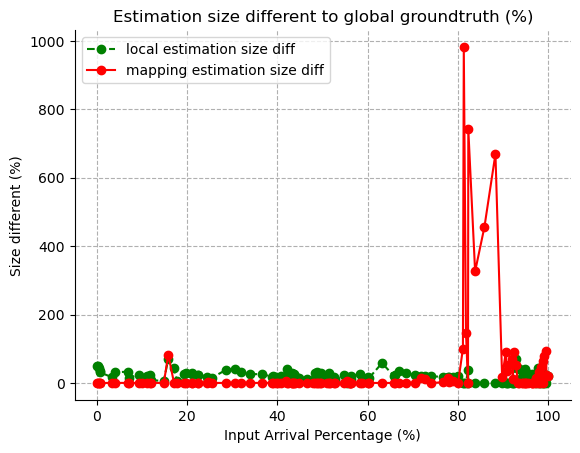

In [468]:
mapping_diff = []
local_diff = []
timer = []
for key in coflow_size_estimation_record.keys():
    timer.append(key)
    global_size = coflow_size_estimation_record[key][1]
    mapping_estimation = coflow_size_estimation_record[key][2]
    local_estimation = coflow_size_estimation_record[key][4][0]
    mapping_diff.append((abs(global_size-mapping_estimation)/global_size)*100)
    local_diff.append((abs(global_size-local_estimation)/global_size)*100)

arrival_percentage = []
for i in range(len(timer)):
    arrival_percentage.append(timer[i]/timer[-1]*100)
filename = "Coflow_size_estiamtion_diff_"+str(numOfSwitches)+"switch_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)
plt.plot(arrival_percentage, local_diff, 'go--')
plt.plot(arrival_percentage, mapping_diff, 'ro-')
'''
plt.plot(arrival_percentage[math.floor(len(arrival_percentage)/2):], local_diff[math.floor(len(local_diff)/2):], 'go--')
plt.plot(arrival_percentage[math.floor(len(arrival_percentage)/2):], mapping_diff[math.floor(len(mapping_diff)/2):], 'ro-')
'''
plt.legend(['local estimation size diff', 'mapping estimation size diff'])
plt.title('Estimation size different to global groundtruth (%)')
plt.xlabel('Input Arrival Percentage (%)')
plt.ylabel('Size different (%)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(linestyle='--')
plt.savefig("plt/" + filename + ".png")
    

In [469]:
new_diff = []
for diff in mapping_diff:
    if diff<=100.0:
        new_diff.append(diff)
print(sum(new_diff)/len(new_diff))
print(sum(local_diff)/len(local_diff))

8.212456328411879
20.53048180333075


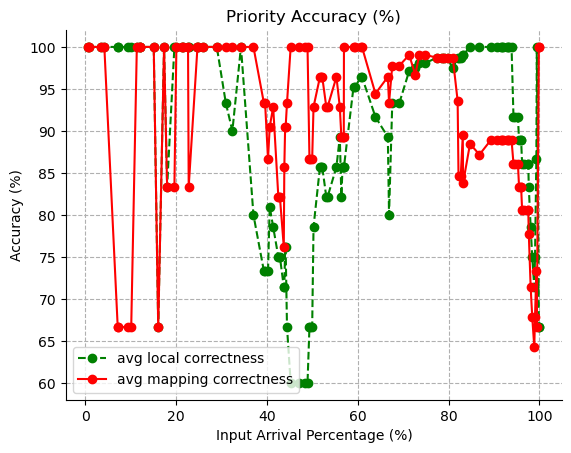

In [470]:
local_correctness = []
mapping_correctness = []
timer = []
for key in priority_result.keys():
    groundtruth = []
    for item in priority_result[key][0]:
        groundtruth.append(item[0])
    local_priority = []
    for item in priority_result[key][1]:
        local_priority.append(item[0])
    mapping_priority = []
    for item in priority_result[key][2]:
        mapping_priority.append(item[0])
    if len(local_priority)==1:
        continue
    timer.append(key)

    correct = 0
    total = 0
    for x in range(len(local_priority)):
        y = x+1
        while(y<len(local_priority)):
            total += 1
            if groundtruth.index(local_priority[x]) < groundtruth.index(local_priority[y]):
                correct += 1
            y+=1
    if total!=0:
        local_correctness.append(correct/total*100)
    else:
        local_correctness.append(0)

    correct = 0
    total = 0
    for x in range(len(mapping_priority)):
        y = x+1
        while(y<len(mapping_priority)):
            total += 1
            if groundtruth.index(mapping_priority[x]) < groundtruth.index(mapping_priority[y]):
                correct += 1
            y+=1
    if total!=0:
        mapping_correctness.append(correct/total*100)
    else:
        mapping_correctness.append(0)

arrival_percentage = []
for i in range(len(timer)):
    arrival_percentage.append(timer[i]/timer[-1]*100)
filename = "Coflow_Priority_Result_"+str(numOfSwitches)+"switch_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)
plt.plot(arrival_percentage, local_correctness, 'go--')
plt.plot(arrival_percentage, mapping_correctness, 'ro-')
'''
plt.plot(arrival_percentage[math.floor(len(arrival_percentage)/2):], local_correctness[math.floor(len(local_correctness)/2):], 'go--')
plt.plot(arrival_percentage[math.floor(len(arrival_percentage)/2):], mapping_correctness[math.floor(len(mapping_correctness)/2):], 'ro-')
'''
plt.legend(['avg local correctness', 'avg mapping correctness'])
plt.title('Priority Accuracy (%)')
plt.xlabel('Input Arrival Percentage (%)')
plt.ylabel('Accuracy (%)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(linestyle='--')
plt.savefig("plt/" + filename + "_average.png")

In [471]:
print(sum(local_correctness)/len(local_correctness))
print(sum(mapping_correctness)/len(mapping_correctness))
print(sum(local_correctness[:math.floor(len(local_correctness)/2)])/math.floor(len(local_correctness)/2))
print(sum(local_correctness[math.floor(len(local_correctness)/2):])/math.floor(len(local_correctness)/2))
print(sum(mapping_correctness[:math.floor(len(mapping_correctness)/2)])/math.floor(len(mapping_correctness)/2))
print(sum(mapping_correctness[math.floor(len(mapping_correctness)/2):])/math.floor(len(mapping_correctness)/2))

88.84825078303336
90.3967192228062
85.87301587301586
93.38222693485852
91.92564745196329
90.45369834843521


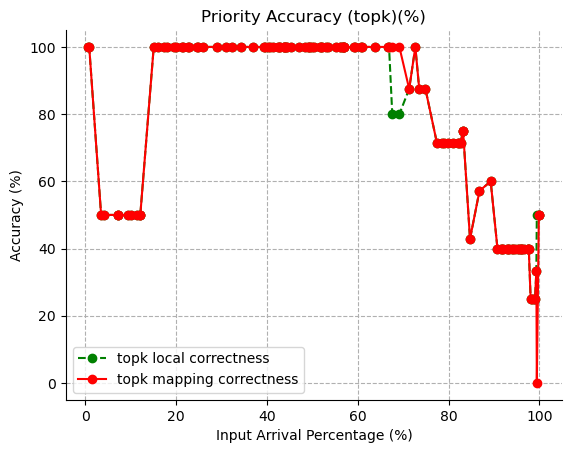

In [480]:
local_correctness_topk = []
mapping_correctness_topk = []
timer = []
k = 0.5
for key in priority_result.keys():
    groundtruth = []
    for item in priority_result[key][0]:
        groundtruth.append(item[0])
    local_priority = []
    for item in priority_result[key][1]:
        local_priority.append(item[0])
    mapping_priority = []
    for item in priority_result[key][2]:
        mapping_priority.append(item[0])
    if len(local_priority)==1:
        continue
    timer.append(key)
    
    groundtruth_topk = groundtruth[math.floor(len(groundtruth)*k):]
    local_priority_topk = local_priority[math.floor(len(local_priority)*k):]
    correct = 0
    total = 0
    for cid in local_priority_topk:
        total+=1
        if cid in groundtruth_topk:
            correct+=1
    if total!=0:
        local_correctness_topk.append(correct/total*100)
    else:
        local_correctness_topk.append(0)

    mapping_priority_topk = mapping_priority[math.floor(len(mapping_priority)*k):]
    correct = 0
    total = 0
    for cid in mapping_priority_topk:
        total+=1
        if cid in groundtruth_topk:
            correct+=1
    if total!=0:
        mapping_correctness_topk.append(correct/total*100)
    else:
        mapping_correctness_topk.append(0)

arrival_percentage = []
for i in range(len(timer)):
    arrival_percentage.append(timer[i]/timer[-1]*100)
filename = "Coflow_Priority_Result_"+str(numOfSwitches)+"switch_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)
plt.plot(arrival_percentage, local_correctness_topk, 'go--')
plt.plot(arrival_percentage, mapping_correctness_topk, 'ro-')
'''
plt.plot(arrival_percentage[:math.floor(len(arrival_percentage)/2)], local_correctness_topk[:math.floor(len(local_correctness_topk)/2)], 'go--')
plt.plot(arrival_percentage[:math.floor(len(arrival_percentage)/2)], mapping_correctness_topk[:math.floor(len(mapping_correctness_topk)/2)], 'ro-')
'''
plt.legend(['topk local correctness', 'topk mapping correctness'])
plt.title('Priority Accuracy (topk)(%)')
plt.xlabel('Input Arrival Percentage (%)')
plt.ylabel('Accuracy (%)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(linestyle='--')
plt.savefig("plt/" + filename + "_topk=" + str(k) + ".png")

In [481]:
print(sum(local_correctness_topk)/len(local_correctness_topk))
print(sum(mapping_correctness_topk)/len(mapping_correctness_topk))
print(sum(local_correctness_topk[:math.floor(len(local_correctness_topk)/5)])/math.floor(len(local_correctness_topk)/5))
print(sum(local_correctness_topk[math.floor(len(local_correctness_topk)/2):])/math.floor(len(local_correctness_topk)/2))
print(sum(mapping_correctness_topk[:math.floor(len(mapping_correctness_topk)/5)])/math.floor(len(mapping_correctness_topk)/5))
print(sum(mapping_correctness_topk[math.floor(len(mapping_correctness_topk)/2):])/math.floor(len(mapping_correctness_topk)/2))

77.36749482401657
77.28053830227745
80.43478260869566
63.987050960735175
80.43478260869566
63.81161236424395


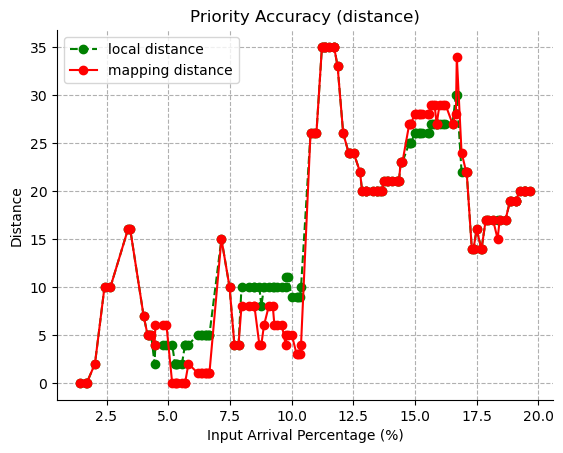

In [190]:
local_distance = []
mapping_distance = []
timer = []
for key in priority_result.keys():
    groundtruth = []
    for item in priority_result[key][0]:
        groundtruth.append(item[0])
    local_priority = []
    for item in priority_result[key][1]:
        local_priority.append(item[0])
    mapping_priority = []
    for item in priority_result[key][2]:
        mapping_priority.append(item[0])
    if len(local_priority)==1:
        continue
    timer.append(key)
    
    distance = 0
    for cid in local_priority:
        distance+=abs(groundtruth.index(cid)-local_priority.index(cid))
    local_distance.append(distance)

    distance = 0
    for cid in mapping_priority:
        distance+=abs(groundtruth.index(cid)-mapping_priority.index(cid))
    mapping_distance.append(distance)

arrival_percentage = []
for i in range(len(timer)):
    arrival_percentage.append(timer[i]/timer[-1]*100)
filename = "Coflow_Priority_Result_"+str(numOfSwitches)+"switch_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)
plt.plot(arrival_percentage[:math.floor(len(arrival_percentage)/2)], local_distance[:math.floor(len(local_distance)/2)], 'go--')
plt.plot(arrival_percentage[:math.floor(len(arrival_percentage)/2)], mapping_distance[:math.floor(len(mapping_distance)/2)], 'ro-')
plt.legend(['local distance', 'mapping distance'])
plt.title('Priority Accuracy (distance)')
plt.xlabel('Input Arrival Percentage (%)')
plt.ylabel('Distance')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(linestyle='--')
plt.savefig("plt/" + filename + "_distance_5.png")

In [191]:
print(sum(local_distance)/len(local_distance))
print(sum(mapping_distance)/len(mapping_distance))
print(sum(local_distance[:math.floor(len(local_distance)/2)])/math.floor(len(local_distance)/2))
print(sum(local_distance[math.floor(len(local_distance)/2):])/math.floor(len(local_distance)/2))
print(sum(mapping_distance[:math.floor(len(mapping_distance)/2)])/math.floor(len(mapping_distance)/2))
print(sum(mapping_distance[math.floor(len(mapping_distance)/2):])/math.floor(len(mapping_distance)/2))

39.32330827067669
39.015037593984964
16.451127819548873
62.19548872180451
15.729323308270677
62.30075187969925


In [380]:
with open("P4_RECORD/Coflow_Priority_Result"+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"_custom.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timer", "global", "local with mapping", "local"])
        for k, v in priority_result.items():
            tmp = [k]
            for item in priority_result[k]:
                tmp.append(item)
            writer.writerow(tmp)

In [8]:
for switch in switches:
    with open("mapping_result"+str(switches.index(switch))+".csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        for k, v in switch.mapping_result.items():
            tmp = [k]
            tmp.extend(v)
            writer.writerow(tmp)

In [27]:
# ------ Record ------
for switch in switches:
    with open(OUTPUT_CSV+str(switches.index(switch)), "w", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(["Time slot", "Size"])
        for i in range(len(switch.priority_table_time)):
            writer.writerow([switch.priority_table_time[i], switch.priority_table_size[i]])
        print("Write Completed")
    with open(OUTPUT_COMPLETION_TIME+str(switches.index(switch)), "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Coflow ID", "Start Time", "Completion Time", "Duration Time", "Coflow Size", "Coflow Priority"])
        for k, v in switch.coflow_completion.items():
            tmp = [k]
            tmp.extend(v)
            writer.writerow(tmp)
# ------ Record ------

Write Completed
Write Completed


In [11]:
for switch in switches:
    with open(OUTPUT_COMPLETION_TIME+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow"+"_"+str(switches.index(switch))+"_"+str(len(sample_input_queue))+"packets.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Coflow ID", "Start Time", "Completion Time", "Duration Time", "Coflow Size", "Coflow Priority"])
        for k, v in switch.coflow_completion.items():
            tmp = [k]
            tmp.extend(v)
            writer.writerow(tmp)

In [15]:
for switch in switches:
    with open("P4_RECORD/classify_accuracy"+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow"+"_"+str(switches.index(switch))+".csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(cid_parition[switches.index(switch)].keys())
        writer.writerow(["Time", "Coflow id", "Major Accuracy", "Major Groundtruth", "Minor Accuracy", "Minor Groundtruth"])
        for k, v in switch.classify_accuracy_table.items():
            tmp = [k]
            tmp.extend(v)
            writer.writerow(tmp)

In [16]:
mergedCCT = mergeCCT(switches)
print(mergedCCT)
with open("P4_RECORD/AverageCCT"+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Coflow ID", "Start Time", "Completion Time", "Duration Time"])
        for k, v in mergedCCT.items():
            tmp = [k]
            tmp.append(v)
            writer.writerow(tmp)

{47.0: [10, 877280, 877270], 5.0: [1390, 4460, 3070], 73.0: [8830, 751670, 742840], 127.0: [11050, 732580, 721530], 211.0: [11860, 732710, 720850], 231.0: [16540, 735860, 719320], 259.0: [14380, 825530, 811150], 274.0: [17100, 889580, 872480], 303.0: [20320, 1635430, 1615110], 389.0: [588920, 848590, 259670], 393.0: [590710, 806280, 215570], 409.0: [596560, 1635670, 1039110], 475.0: [664130, 1081090, 416960], 503.0: [664330, 1637650, 973320], 11.0: [3940, 733100, 729160], 176.0: [11410, 756230, 744820], 264.0: [15490, 720970, 705480], 300.0: [20060, 792360, 772300], 308.0: [605830, 1079920, 474090], 'AverageCCT': 706005.2631578947}


In [319]:
with open("P4_RECORD/CoflowSize_Estimation_Record"+"_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow_"+str(len(sample_input_queue))+"packets_alpha="+str(alpha)+".csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timer", "real cid", "global groundtruth", "global estimation", "local groundtruth", "local estimation", "queue sizes"])
        for k, v in coflow_size_estimation_record.items():
            tmp = [k]
            for item in v:
                tmp.append(item)
            writer.writerow(tmp)

In [18]:
for switch in switches:
    with open("P4_RECORD/classify_result_"+str(len(sample_f_id_list))+"flows_"+str(len(sample_input_queue))+"packets_"+str(numOfSwitches)+"switch"+"_"+str(numofCoflows)+"coflow"+"_"+str(switches.index(switch))+".csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Time", "Real cid", "Classified cid", "Score", "Queue Distribution", "Representive", "Percentage", "Queue Size", "Dominated"])
        for k, v in switch.classify_result_table.items():
            tmp = [k]
            tmp.extend(v)
            writer.writerow(tmp)

In [14]:
partial = []
for key in switches[0].classify_result_table.keys():
    if switches[0].classify_result_table[key][0] == True and switches[0].classify_result_table[key][4]<=0.2:
        partial.append(switches[0].classify_result_table[key])
for item in partial:
    print(item)

[True, 90.0, 17.0, 0.045297022350132464, 0.038461538461538464, {17.0: {17.0: 1, 56.0: 24, 90.0: 1}, 20.0: {20.0: 7, 56.0: 11}, 55.0: {55.0: 18, 56.0: 1}, 59.0: {59.0: 2, 56.0: 6}, 56.0: {56.0: 172}}]
[True, 250.0, 227.0, 0.10374513640999794, 0.2, {93.0: {93.0: 5}, 119.0: {119.0: 13}, 129.0: {129.0: 2, 212.0: 1}, 177.0: {177.0: 3}, 204.0: {204.0: 1}, 227.0: {227.0: 1, 250.0: 4}}]
[True, 270.0, 227.0, 0.058754554390907286, 0.16666666666666666, {93.0: {93.0: 5}, 119.0: {119.0: 13}, 129.0: {129.0: 2, 212.0: 1}, 177.0: {177.0: 3}, 204.0: {204.0: 1}, 227.0: {227.0: 1, 250.0: 4, 270.0: 1}, 265.0: {265.0: 1}}]
[True, 270.0, 227.0, 0.06908884520332019, 0.14285714285714285, {93.0: {93.0: 5}, 119.0: {119.0: 13}, 129.0: {129.0: 2, 212.0: 1}, 177.0: {177.0: 3}, 204.0: {204.0: 1}, 227.0: {227.0: 1, 250.0: 4, 270.0: 2}, 265.0: {265.0: 1}}]
[True, 274.0, 265.0, 0.11005231738090515, 0.2, {93.0: {93.0: 5}, 119.0: {119.0: 13}, 129.0: {129.0: 2, 212.0: 1}, 177.0: {177.0: 3}, 204.0: {204.0: 1}, 227.0: {227